## Requirements

In [ ]:
!pip install ncps
!pip install keras-ncp
!pip install tensorflow-addons
!pip install punkt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement punkt (from versions: none)
ERROR: No matching distribution found for punkt


### Move Train to train folder

In [ ]:
import os
import pandas as pd
import shutil

In [ ]:
languages = ["Bhojpuri", "Gujarati", "Haryanvi", "Hindi", "Kannada", "Malayalam", "Odia", "Punjabi", "Tamil", "Bengali"]

In [ ]:
# Iterate over each language
for language in languages:
    # Paths
    spectrogram_dir = f"D:/college/Phase 2 Project/adima/audios-001/Spectrogram/{language}/"
    annotations_file = f"D:/college/Phase 2 Project/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_train.csv/"
    test_annotations_file = f"D:/college/Phase 2 Project/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_test.csv/"
    train_dir = f"D:/college/Phase 2 Project/adima/audios-001/Spectrogram/{language}/train"
    test_dir = f"D:/college/Phase 2 Project/adima/audios-001/Spectrogram/{language}/test"

    # Create the train directory if it doesn't exist
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    # Read annotations
    annotations_df = pd.read_csv(annotations_file)

    # Iterate through annotations and move corresponding spectrogram images for training
    for index, row in annotations_df.iterrows():
        filename = row['filename']
        spectrogram_path = os.path.join(spectrogram_dir, filename.replace(".wav", "_spectrogram.png"))
        if os.path.exists(spectrogram_path):
            shutil.move(spectrogram_path, os.path.join(train_dir, os.path.basename(spectrogram_path)))

    print(f"Training images for {language} moved successfully to the train folder.")

    # Read annotations for testing
    annotations_df = pd.read_csv(test_annotations_file)

    # Iterate through annotations and move corresponding spectrogram images for testing
    for index, row in annotations_df.iterrows():
        filename = row['filename']
        spectrogram_path = os.path.join(spectrogram_dir, filename.replace(".wav", "_spectrogram.png"))
        if os.path.exists(spectrogram_path):
            shutil.move(spectrogram_path, os.path.join(test_dir, os.path.basename(spectrogram_path)))

    print(f"Testing images for {language} moved successfully to the test folder.")

# Monolingual

## CNN (Spectrogram)

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
train_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Bengali_train.csv'
test_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Bengali_test.csv'
spectrogram_train_path = '/content/drive/MyDrive/adima/Spectrogram/Bengali/train'
spectrogram_test_path = '/content/drive/MyDrive/adima/Spectrogram/Bengali/test'

In [ ]:
train_annotations = pd.read_csv(train_annotations_path)
test_annotations = pd.read_csv(test_annotations_path)

In [ ]:
def load_spectrogram_image(filename, spectrogram_path):
    img_path = os.path.join(spectrogram_path, filename.replace('.wav', '_spectrogram.png'))
    img = load_img(img_path, color_mode="grayscale", target_size=(100, 100))
    img_array = img_to_array(img)
    return img_array / 255.0

In [ ]:
X_train_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_train_path) for filename in train_annotations['filename']])
y_train_spectrogram = np.array(train_annotations['label'].map({'Yes': 1, 'No': 0}))
X_test_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
y_test_spectrogram = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

In [ ]:
cnn_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 256)       0

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = cnn_model.fit(X_train_spectrogram, y_train_spectrogram, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
21/21 [==============================] - 7s 82ms/step - loss: 0.7160 - accuracy: 0.5388 - val_loss: 0.6867 - val_accuracy: 0.6000
Epoch 2/50
21/21 [==============================] - 1s 27ms/step - loss: 0.6936 - accuracy: 0.5068 - val_loss: 0.6915 - val_accuracy: 0.6667
Epoch 3/50
21/21 [==============================] - 1s 27ms/step - loss: 0.6931 - accuracy: 0.5084 - val_loss: 0.7016 - val_accuracy: 0.4000
Epoch 4/50
21/21 [==============================] - 1s 27ms/step - loss: 0.6960 - accuracy: 0.5053 - val_loss: 0.6964 - val_accuracy: 0.4000
Epoch 5/50
21/21 [==============================] - 1s 27ms/step - loss: 0.6922 - accuracy: 0.5160 - val_loss: 0.6786 - val_accuracy: 0.6000
Epoch 6/50
21/21 [==============================] - 0s 23ms/step - loss: 0.6941 - accuracy: 0.4916 - val_loss: 0.6826 - val_accuracy: 0.6364
Epoch 7/50
21/21 [==============================] - 0s 24ms/step - loss: 0.6838 - accuracy: 0.5449 - val_loss: 0.6459 - val_accuracy: 0.6303
Epoch 8/50
21

In [ ]:
# Define the file path to save the model
model_path = '/content/drive/MyDrive/adima/model1_cnn_spectrogram.h5'
# Save the model
cnn_model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
train_predictions = cnn_model.predict(X_train_spectrogram)
test_predictions = cnn_model.predict(X_test_spectrogram)

train_accuracy = accuracy_score(y_train_spectrogram, np.round(train_predictions))
test_accuracy = accuracy_score(y_test_spectrogram, np.round(test_predictions))

train_f1_score = f1_score(y_train_spectrogram, np.round(train_predictions))
test_f1_score = f1_score(y_test_spectrogram, np.round(test_predictions))

train_auc = roc_auc_score(y_train_spectrogram, train_predictions)
test_auc = roc_auc_score(y_test_spectrogram, test_predictions)

12/12 [==============================] - 0s 25ms/step


In [ ]:
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("Training F1 Score:", train_f1_score)
print("Testing F1 Score:", test_f1_score)
print("Training AUC:", train_auc)
print("Testing AUC:", test_auc)

Training Accuracy: 0.6897810218978102
Testing Accuracy: 0.7351351351351352
Training F1 Score: 0.7559808612440191
Testing F1 Score: 0.8063241106719369
Training AUC: 0.8337563451776651
Testing AUC: 0.800645239834429


In [ ]:
print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)
print("Testing AUC:", test_auc)

Testing Accuracy: 0.7351351351351352
Testing F1 Score: 0.8063241106719369
Testing AUC: 0.800645239834429


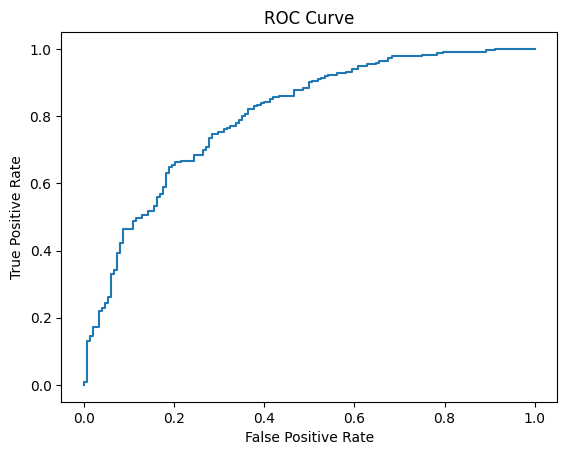

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_spectrogram, test_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

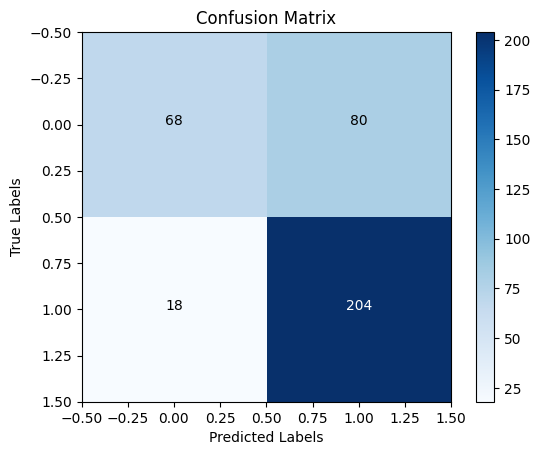

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred_binary = np.round(test_predictions).astype(int)

cm = confusion_matrix(y_test_spectrogram, y_pred_binary)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

## LNN

In [ ]:
from ncps.wirings import AutoNCP
from ncps.tf import LTC
import tensorflow as tf
from ncps import wirings
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint
import kerasncp as kncp
from kerasncp.tf import LTCCell
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'ncps'

### IMAGE

In [ ]:
# Load training images and preprocess them
train_image_dir = '/content/drive/MyDrive/adima/Spectrogram/Bengali/train'
train_image_filenames = os.listdir(train_image_dir)
train_images = []
for filename in train_image_filenames:
    img = load_img(os.path.join(train_image_dir, filename), target_size=(150, 150))  # Adjust target_size as needed
    img_array = img_to_array(img)
    train_images.append(img_array)
train_images = np.array(train_images) / 255.0  # Normalize pixel values

# Load training annotations
train_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Bengali_train.csv'
train_annotations_df = pd.read_csv(train_annotations_path)

# Prepare training data
train_labels = []
for filename in train_image_filenames:
    label = train_annotations_df.loc[train_annotations_df['filename'] == filename.replace('_spectrogram.png', '.wav'), 'label'].values[0]
    train_labels.append(1 if label == 'Yes' else 0)
train_labels = np.array(train_labels)

In [ ]:
# Load testing images and preprocess them
test_image_dir = '/content/drive/MyDrive/adima/Spectrogram/Bengali/test'
test_image_filenames = os.listdir(test_image_dir)
test_images = []
test_labels = []
test_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Bengali_test.csv'
test_annotations_df = pd.read_csv(test_annotations_path)

for filename in test_image_filenames:
    img = load_img(os.path.join(test_image_dir, filename), target_size=(150, 150))  # Adjust target_size as needed
    img_array = img_to_array(img)

    wav_filename = filename.replace('_spectrogram.png', '.wav')
    label = test_annotations_df.loc[test_annotations_df['filename'] == wav_filename, 'label'].values

    if len(label) > 0:
        test_images.append(img_array)
        test_labels.append(1 if label[0] == 'Yes' else 0)
    else:
        print(f"No label found for {wav_filename}. Skipping image {filename}.")
        continue

test_images = np.array(test_images) / 255.0  # Normalize pixel values
test_labels = np.array(test_labels)

No label found for Abuse_297.wav. Skipping image Abuse_297_spectrogram.png.
No label found for Abuse_30.wav. Skipping image Abuse_30_spectrogram.png.
No label found for Abuse_374.wav. Skipping image Abuse_374_spectrogram.png.
No label found for Abuse_456.wav. Skipping image Abuse_456_spectrogram.png.
No label found for Abuse_496.wav. Skipping image Abuse_496_spectrogram.png.
No label found for Abuse_514.wav. Skipping image Abuse_514_spectrogram.png.
No label found for Abuse_563.wav. Skipping image Abuse_563_spectrogram.png.
No label found for Abuse_649.wav. Skipping image Abuse_649_spectrogram.png.




```
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification, so output layer has 1 neuron with sigmoid activation
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

model.summary()
```



In [ ]:
input_shape = train_images.shape[1:]  # Assuming train_images is already shaped as (num_samples, height, width, channels)


```
# This is formatted as code
# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Reshape((1, -1)),  # Reshape for LSTM
    layers.RNN(rnn_cell, return_sequences=True),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')  # Binary classification, so output layer has 1 neuron with sigmoid activation
])
```





```
# This is formatted as code
# Define the LTC cell
wiring = AutoNCP(100, 25)
rnn_cell = LTCCell(wiring)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),  # Additional Conv2D layer
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Reshape((1, -1)),  # Reshape for LSTM
    layers.RNN(rnn_cell, return_sequences=True),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),  # Additional dense layer
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(1, activation='sigmoid')
])
```



In [ ]:
from skimage.feature import local_binary_pattern

# Define a function to compute RLBP features for a single image
def compute_rlbp(image):
    # Compute RLBP features
    lbp_image = local_binary_pattern(image, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, 10), range=(0, 9))
    return hist

# Define a custom layer to compute RLBP features for a batch of images
class RLBPFeatures(layers.Layer):
    def call(self, inputs):
        rlbp_features = []
        for image in inputs:
            rlbp_feature = compute_rlbp(image.numpy())
            rlbp_features.append(rlbp_feature)
        return tf.convert_to_tensor(rlbp_features)

# Define the model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),  # Additional dense layer
    RLBPFeatures(),  # Custom RLBP layer
    layers.Dense(64, activation='relu'),  # Additional dense layer
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),  # Additional Conv2D layer
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # Additional dense layer
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(1, activation='sigmoid')
])


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 17, 17, 128)      

In [ ]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                    )
class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{0: 1.0431472081218274, 1: 0.9602803738317757}

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Pass early_stopping callback to model.fit()
history = model.fit(train_images, train_labels, epochs=15, batch_size=32, validation_split=0.2, class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/15
21/21 [==============================] - 42s 2s/step - loss: 0.7295 - accuracy: 0.5282 - val_loss: 0.6714 - val_accuracy: 0.6182
Epoch 2/15
21/21 [==============================] - 37s 2s/step - loss: 0.6401 - accuracy: 0.6530 - val_loss: 0.5922 - val_accuracy: 0.7152
Epoch 3/15
21/21 [==============================] - 36s 2s/step - loss: 0.5932 - accuracy: 0.6880 - val_loss: 0.6533 - val_accuracy: 0.6545
Epoch 4/15
21/21 [==============================] - 37s 2s/step - loss: 0.5995 - accuracy: 0.6910 - val_loss: 0.5681 - val_accuracy: 0.7030
Epoch 5/15
21/21 [==============================] - 36s 2s/step - loss: 0.5632 - accuracy: 0.7047 - val_loss: 0.5678 - val_accuracy: 0.7515
Epoch 6/15
21/21 [==============================] - 37s 2s/step - loss: 0.5729 - accuracy: 0.6986 - val_loss: 0.5414 - val_accuracy: 0.7394
Epoch 7/15
21/21 [==============================] - 34s 2s/step - loss: 0.5363 - accuracy: 0.7321 - val_loss: 0.5347 - val_accuracy: 0.7333
Epoch 8/15
21/21 [==

In [ ]:
model.save('/content/drive/MyDrive/adima/model_cnn_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)

12/12 [==============================] - 6s 529ms/step


In [ ]:
print(len(test_labels))
print(len(test_images))
print(len(test_predictions_classes))

370
370
370


In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, test_predictions_classes)
#f1 = f1_score(test_labels, test_predictions_classes)
precision = precision_score(test_labels, test_predictions_classes)
roc_auc = roc_auc_score(test_labels, test_predictions_classes)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


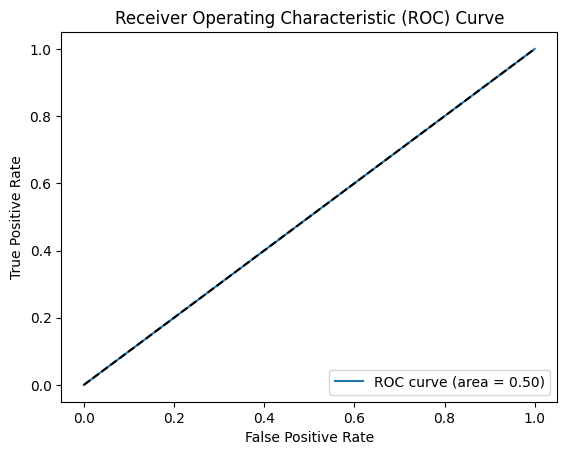

In [ ]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_predictions_classes)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Print evaluation metrics
print("Accuracy:", accuracy)
#print("F1 Score:", f1)
print("Precision:", precision)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.4
Precision: 0.0
ROC AUC Score: 0.5


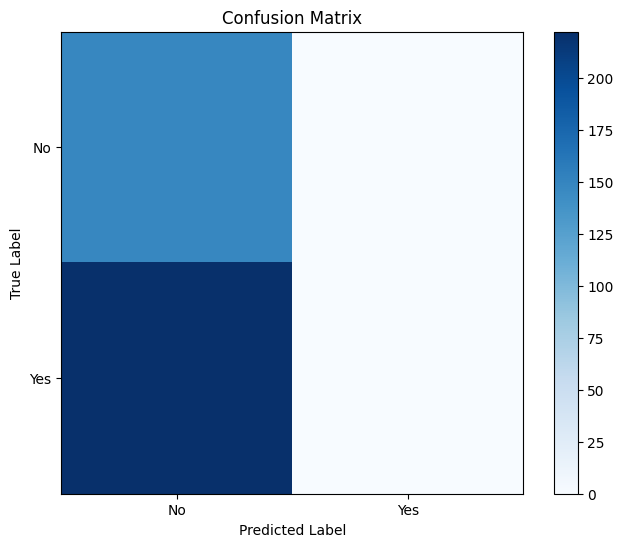

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_classes)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['No', 'Yes'])
plt.yticks([0, 1], ['No', 'Yes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### TEXT

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models, layers
from kerasncp.tf import LTCCell
from tensorflow.keras.layers import RNN
from tensorflow.keras import models, layers, preprocessing
from ncps.wirings import AutoNCP
from ncps.tf import LTC
import tensorflow as tf
from ncps import wirings
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint
import kerasncp as kncp
from kerasncp.tf import LTCCell
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [ ]:
# Load annotation data
annotation_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Bengali_train.csv'
annotation_data = pd.read_csv(annotation_path)

# Load text data
text_path = '/content/drive/MyDrive/adima/audios-001/Transcriptions/transcription_bengali.csv'
text_data = pd.read_csv(text_path)

# Merge annotation and text data
merged_data = pd.merge(annotation_data, text_data, left_on='filename', right_on='File Name', how='inner')

# Filter out unnecessary columns
merged_data = merged_data[['Transcription', 'label']]

# Prepare data for training
X_text = merged_data['Transcription'].values
y = merged_data['label'].values

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train and test sets
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# Tokenize text data
max_words = 10000  # Maximum number of words to tokenize
max_len = 100  # Maximum length of each sequence
tokenizer = preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_text)
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences to ensure uniform length
X_train_pad = preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/adima/audios-001/Transcriptions/transcription_bengali.csv'

In [ ]:
# Define the LTC cell
wiring = AutoNCP(100, 25)
rnn_cell = LTCCell(wiring)

# Define the model
model = models.Sequential([
    layers.Embedding(max_words, 32, input_length=max_len),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Reshape((1, -1)),  # Reshape for LSTM
    layers.RNN(rnn_cell, return_sequences=True),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 32)           320000    
                                                                 
 conv1d_9 (Conv1D)           (None, 98, 32)            3104      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 49, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 47, 64)            6208      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 21, 64)          

In [ ]:
# Train the model
model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/10
14/14 [==============================] - 15s 328ms/step - loss: 0.6800 - accuracy: 0.5882 - val_loss: 0.6729 - val_accuracy: 0.6036
Epoch 2/10
14/14 [==============================] - 2s 134ms/step - loss: 0.6789 - accuracy: 0.5882 - val_loss: 0.6716 - val_accuracy: 0.6036
Epoch 3/10
14/14 [==============================] - 2s 113ms/step - loss: 0.6785 - accuracy: 0.5882 - val_loss: 0.6716 - val_accuracy: 0.6036
Epoch 4/10
14/14 [==============================] - 2s 121ms/step - loss: 0.6776 - accuracy: 0.5882 - val_loss: 0.6729 - val_accuracy: 0.6036
Epoch 5/10
14/14 [==============================] - 1s 72ms/step - loss: 0.6772 - accuracy: 0.5882 - val_loss: 0.6726 - val_accuracy: 0.6036
Epoch 6/10
14/14 [==============================] - 1s 76ms/step - loss: 0.6745 - accuracy: 0.5882 - val_loss: 0.6702 - val_accuracy: 0.6036
Epoch 7/10
14/14 [==============================] - 1s 54ms/step - loss: 0.6639 - accuracy: 0.5882 - val_loss: 0.6603 - val_accuracy: 0.6036
Epoch 8/

In [ ]:
# Define the file path to save the model
model_path = '/content/drive/MyDrive/adima/model3_text.h5'

# Save the model
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load testing annotation data
testing_annotation_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Bengali_test.csv'
testing_annotation_data = pd.read_csv(testing_annotation_path)

# Load testing text data
testing_text_path = '/content/drive/MyDrive/adima/audios-001/Transcriptions/transcription_bengali.csv'
testing_text_data = pd.read_csv(testing_text_path)

# Merge testing annotation and text data
merged_testing_data = pd.merge(testing_annotation_data, testing_text_data, left_on='filename', right_on='File Name', how='inner')

# Filter out unnecessary columns
merged_testing_data = merged_testing_data[['Transcription', 'label']]

# Prepare data for testing
X_test_text = merged_testing_data['Transcription'].values
y_test = merged_testing_data['label'].values

# Encode labels
y_test_encoded = label_encoder.transform(y_test)

# Tokenize and pad sequences for testing data
X_test_seq = tokenizer.texts_to_sequences(X_test_text)
X_test_pad = preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype(int)

9/9 [==============================] - 1s 4ms/step


In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
f1 = f1_score(y_test_encoded, y_pred)
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7238805970149254
F1 Score: 0.8072916666666666
Confusion Matrix:
[[ 39  54]
 [ 20 155]]


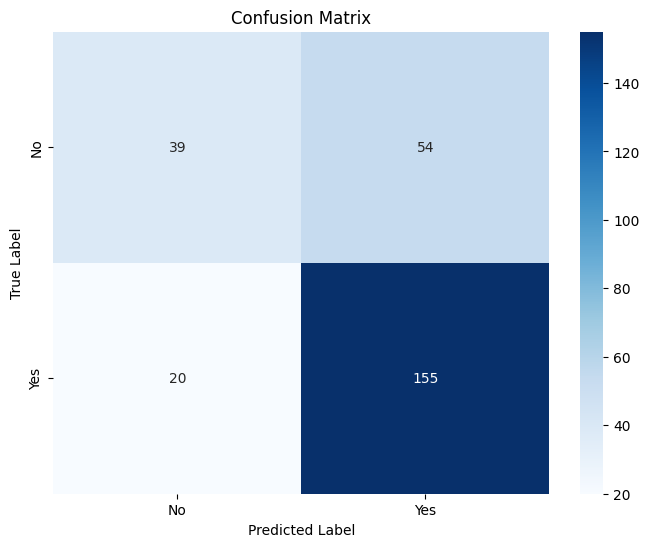

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix as heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Combining

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Load predictions from CNN model
cnn_train_predictions = cnn_model.predict(X_train_spectrogram)
cnn_test_predictions = cnn_model.predict(X_test_spectrogram)

12/12 [==============================] - 0s 6ms/step


In [ ]:
# Load predictions from LSTM model
lstm_train_predictions = model.predict(X_train_pad)
lstm_test_predictions = model.predict(X_test_pad)

9/9 [==============================] - 0s 5ms/step


In [ ]:
# Calculate accuracies
cnn_accuracy = accuracy_score(y_test_spectrogram, np.round(cnn_test_predictions))
lstm_accuracy = accuracy_score(y_test_encoded, np.round(lstm_test_predictions))

# Assign weights based on accuracies
total_accuracy = cnn_accuracy + lstm_accuracy
cnn_weight = cnn_accuracy / total_accuracy
lstm_weight = lstm_accuracy / total_accuracy

print("CNN Accuracy:", cnn_accuracy)
print("LSTM Accuracy:", lstm_accuracy)
print("Assigned weights - CNN:", cnn_weight, "LSTM:", lstm_weight)

CNN Accuracy: 0.6
LSTM Accuracy: 0.7238805970149254
Assigned weights - CNN: 0.45321307779030434 LSTM: 0.5467869222096956


In [ ]:
# Combine predictions selectively where both models have predictions
train_combined_predictions = []
for i in range(len(y_train)):
    if i < len(cnn_train_predictions) and i < len(lstm_train_predictions):
        combined_pred = np.round((cnn_weight * cnn_train_predictions[i]) + (lstm_weight * lstm_train_predictions[i]))
    elif i < len(cnn_train_predictions):
        combined_pred = np.round(cnn_weight * cnn_train_predictions[i])
    else:
        combined_pred = np.round(lstm_weight * lstm_train_predictions[i])
    train_combined_predictions.append(combined_pred)

# Combine predictions for test data similarly
test_combined_predictions = []
for i in range(len(y_test)):
    if i < len(cnn_test_predictions) and i < len(lstm_test_predictions):
        combined_pred = np.round((cnn_weight * cnn_test_predictions[i]) + (lstm_weight * lstm_test_predictions[i]))
    elif i < len(cnn_test_predictions):
        combined_pred = np.round(cnn_weight * cnn_test_predictions[i])
    else:
        combined_pred = np.round(lstm_weight * lstm_test_predictions[i])
    test_combined_predictions.append(combined_pred)

In [ ]:
print(train_combined_predictions)
print(test_combined_predictions)

[array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=f

In [ ]:
# Convert true labels to match the format of predicted labels
y_test = np.array([1 if label == 'Yes' else 0 for label in y_test])
print("Unique values in y_train_pred_format:", np.unique(y_test))

Unique values in y_train_pred_format: [0 1]


In [ ]:
# Calculate accuracy and other metrics
train_accuracy = accuracy_score(y_train, train_combined_predictions)
test_accuracy = accuracy_score(y_test, test_combined_predictions)
train_f1_score = f1_score(y_train, train_combined_predictions)
test_f1_score = f1_score(y_test, test_combined_predictions)
train_auc = roc_auc_score(y_train, train_combined_predictions)
test_auc = roc_auc_score(y_test, test_combined_predictions)

print("Training Accuracy:", train_accuracy)
print("Training F1 Score:", train_f1_score)
print("Training AUC:", train_auc)
print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)
print("Testing AUC:", test_auc)

Training Accuracy: 0.9411764705882353
Training F1 Score: 0.951851851851852
Training AUC: 0.9310439560439561
Testing Accuracy: 0.7388059701492538
Testing F1 Score: 0.8205128205128205
Testing AUC: 0.6614439324116743


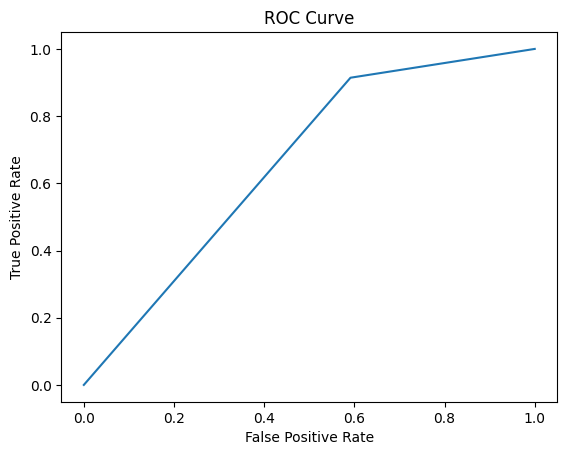

In [ ]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_combined_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

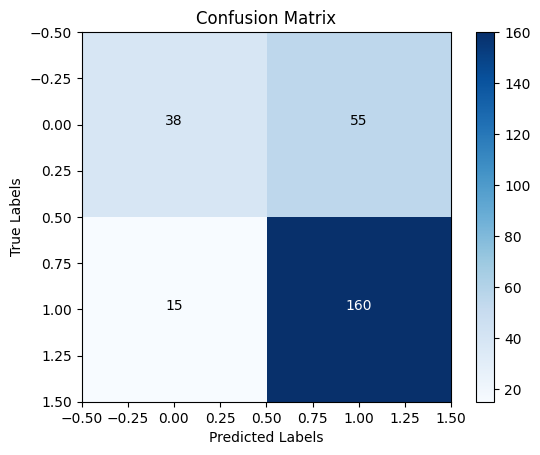

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, test_combined_predictions)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()


# Cross Lingual Adaptation

## CNN

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 256)       0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.
Evaluating for language: Bhojpuri
24/24 [==============================] - 12s 504ms/step
Accuracy: 0.766798418972332
F1 Score: 0.8245787908820614
AUC: 0.8173694324235655
Results for Bhojpuri saved successfully.


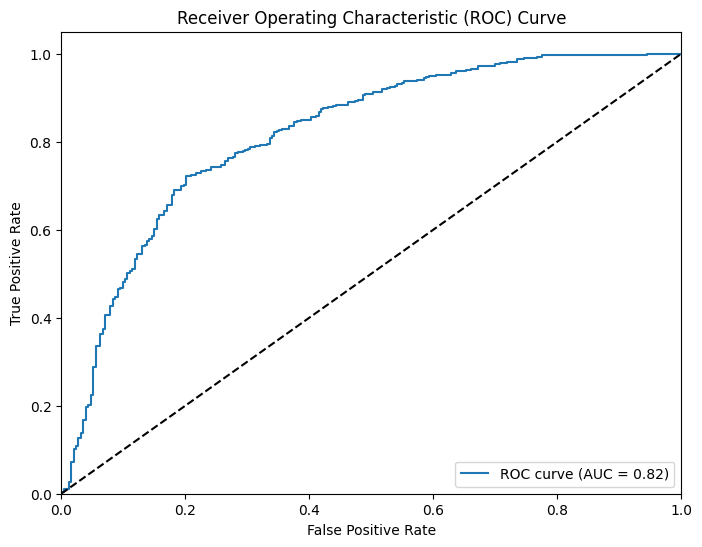

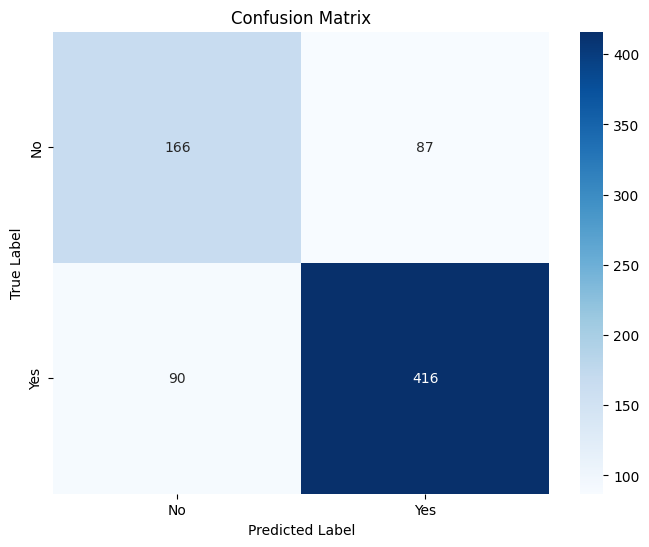

Evaluating for language: Gujarati
26/26 [==============================] - 20s 775ms/step
Accuracy: 0.7258261933904528
F1 Score: 0.6636636636636637
AUC: 0.81924592443792
Results for Gujarati saved successfully.


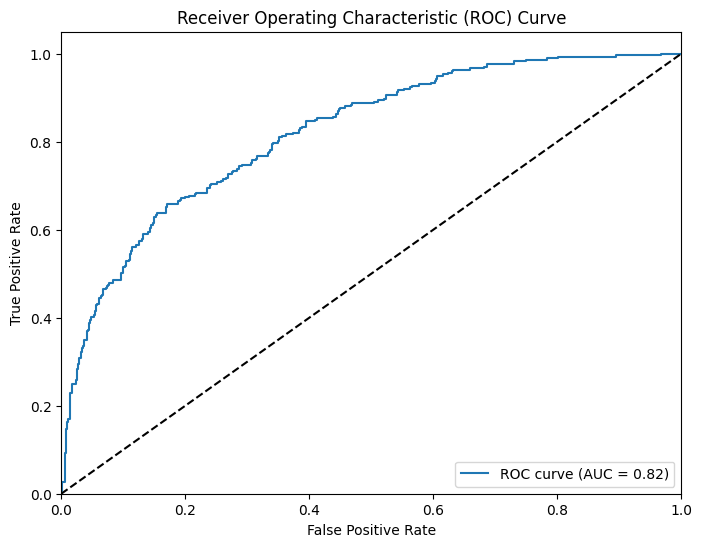

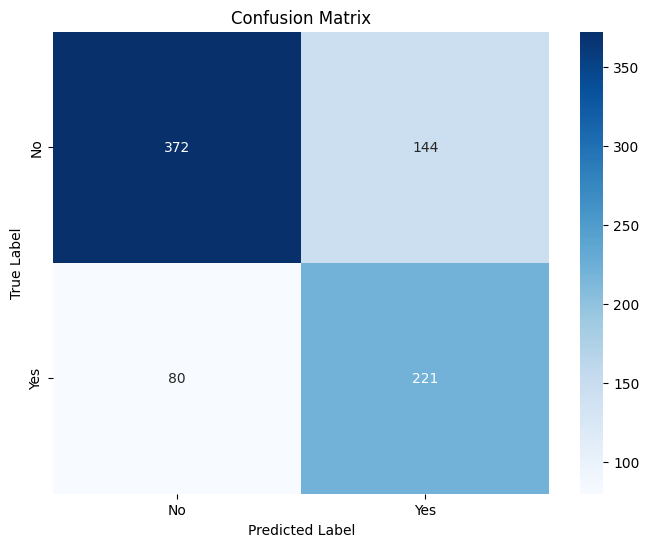

Evaluating for language: Haryanvi
26/26 [==============================] - 13s 479ms/step
Accuracy: 0.7506112469437652
F1 Score: 0.755980861244019
AUC: 0.8382710953995969
Results for Haryanvi saved successfully.


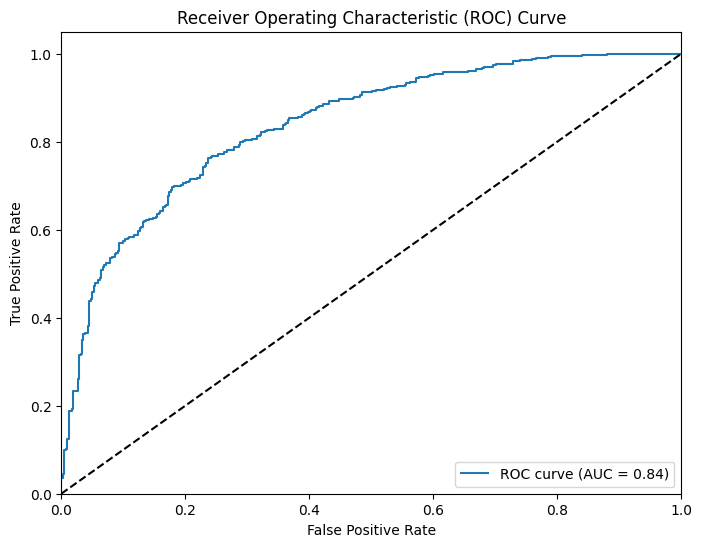

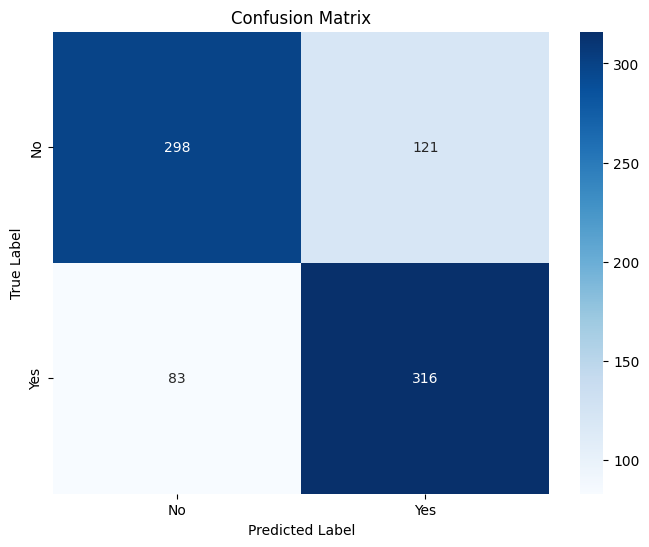

Evaluating for language: Hindi
26/26 [==============================] - 13s 499ms/step
Accuracy: 0.7335766423357665
F1 Score: 0.7345454545454546
AUC: 0.8314932796742238
Results for Hindi saved successfully.


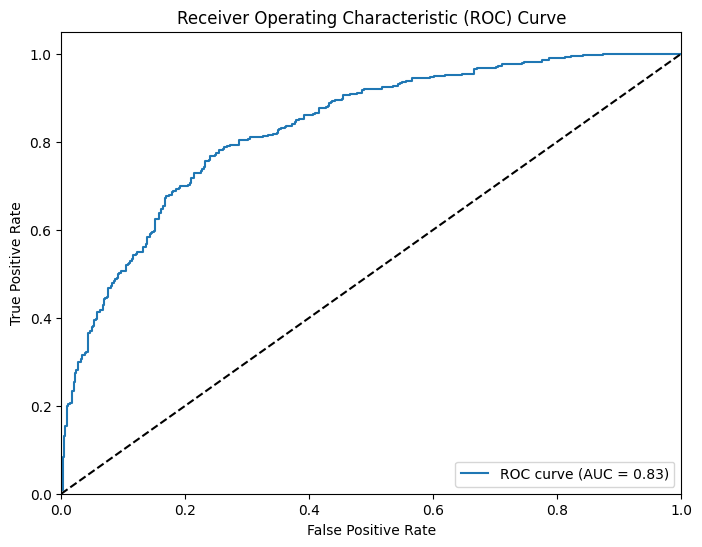

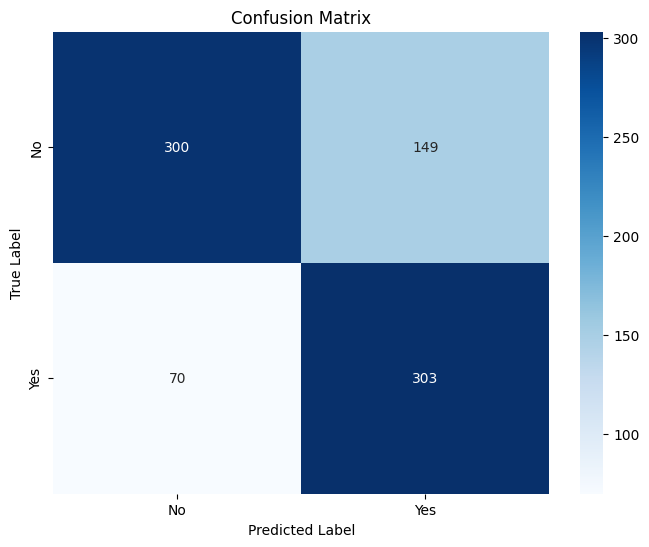

Evaluating for language: Kannada
26/26 [==============================] - 12s 442ms/step
Accuracy: 0.7106227106227107
F1 Score: 0.6414523449319214
AUC: 0.8054057583077628
Results for Kannada saved successfully.


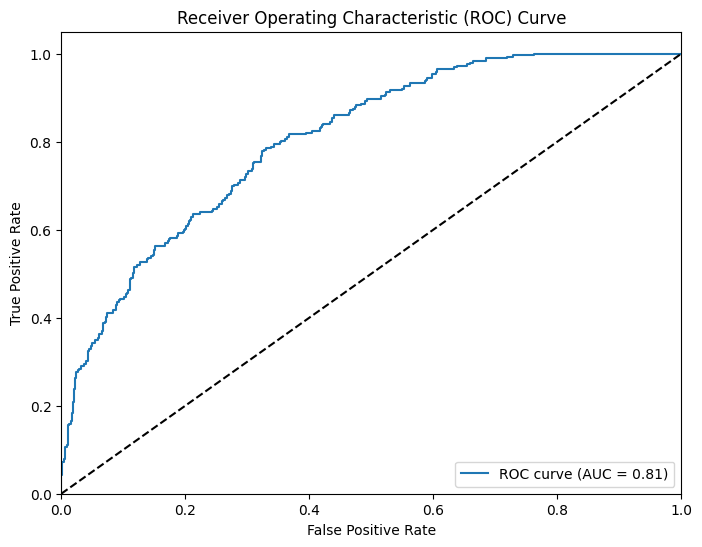

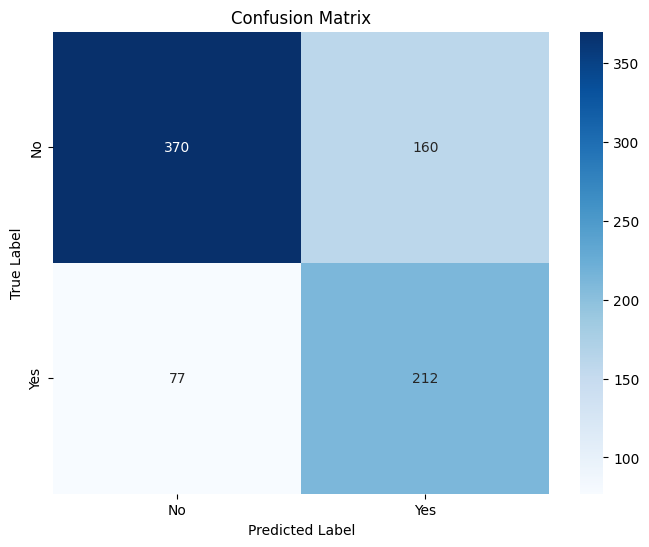

Evaluating for language: Malayalam
26/26 [==============================] - 12s 439ms/step
Accuracy: 0.746031746031746
F1 Score: 0.6521739130434783
AUC: 0.8474125306305914
Results for Malayalam saved successfully.


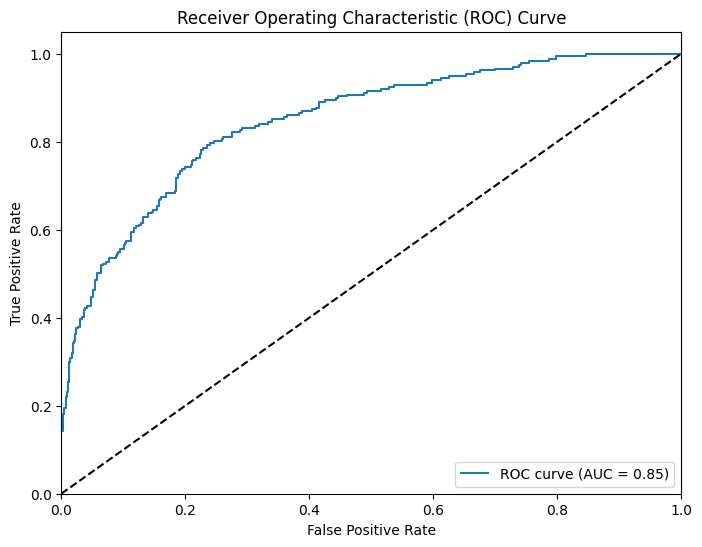

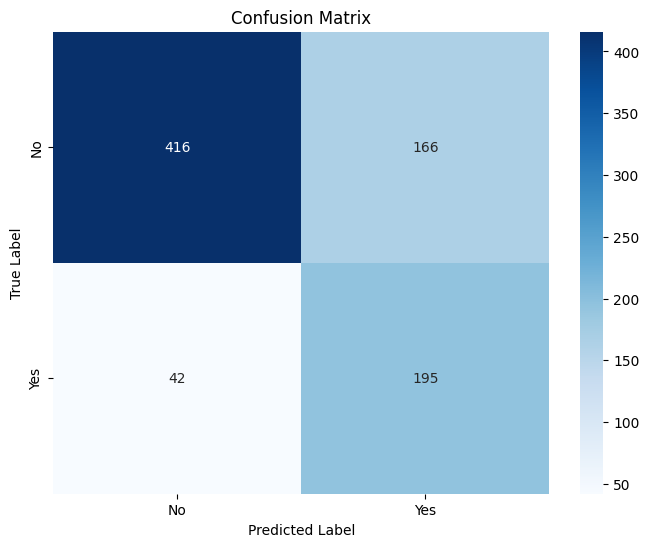

Evaluating for language: Odia
26/26 [==============================] - 12s 463ms/step
Accuracy: 0.8058968058968059
F1 Score: 0.764179104477612
AUC: 0.8961997061660981
Results for Odia saved successfully.


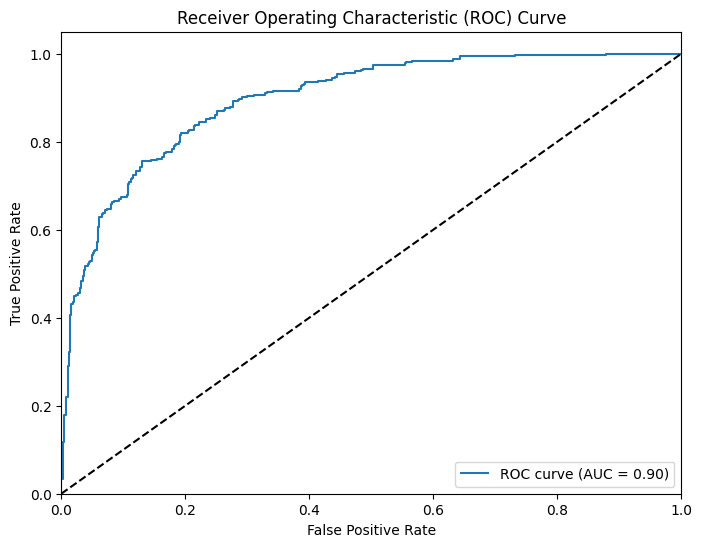

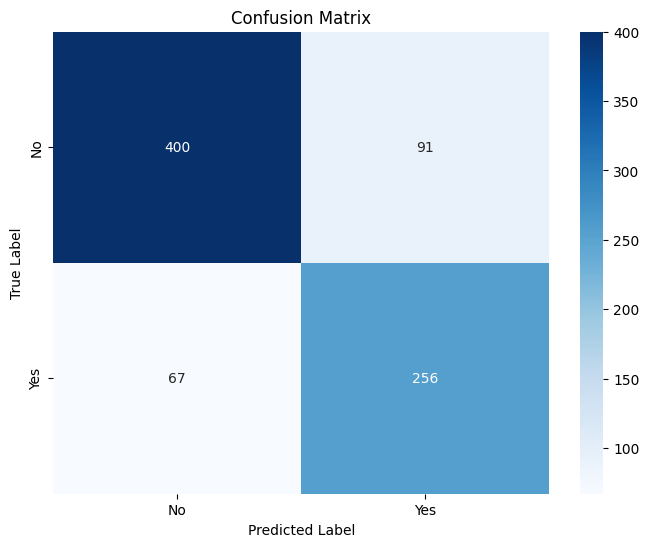

Evaluating for language: Punjabi
26/26 [==============================] - 13s 519ms/step
Accuracy: 0.7799511002444988
F1 Score: 0.801762114537445
AUC: 0.8842973724329657
Results for Punjabi saved successfully.


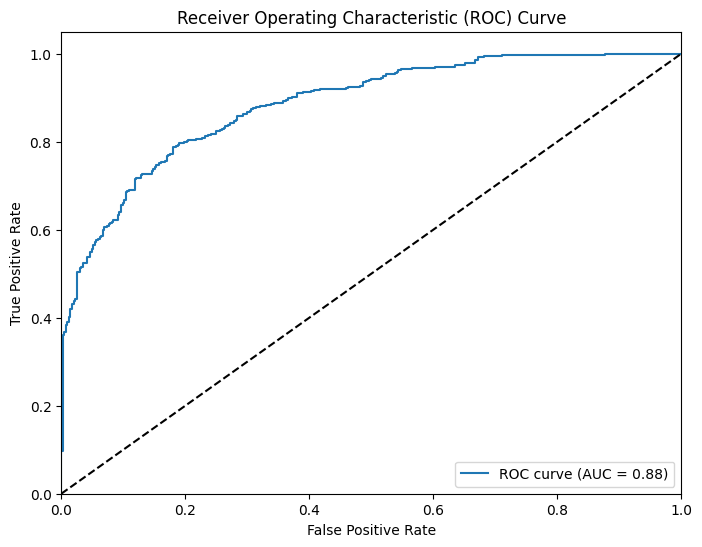

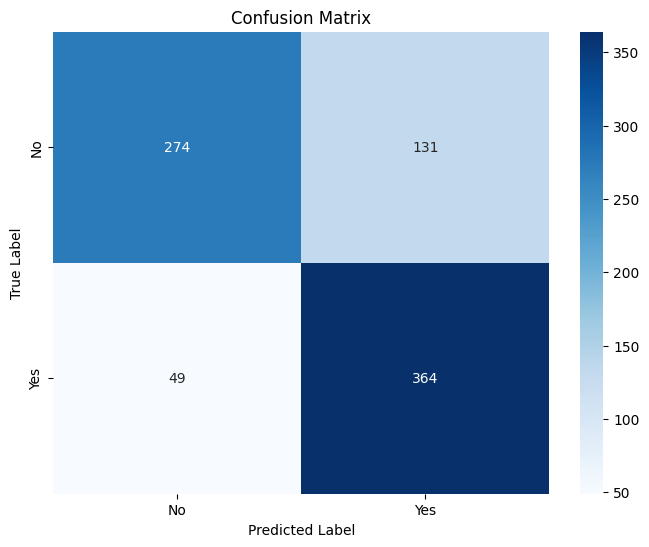

Evaluating for language: Tamil
26/26 [==============================] - 12s 438ms/step
Accuracy: 0.7536585365853659
F1 Score: 0.6493055555555555
AUC: 0.8440742725016919
Results for Tamil saved successfully.


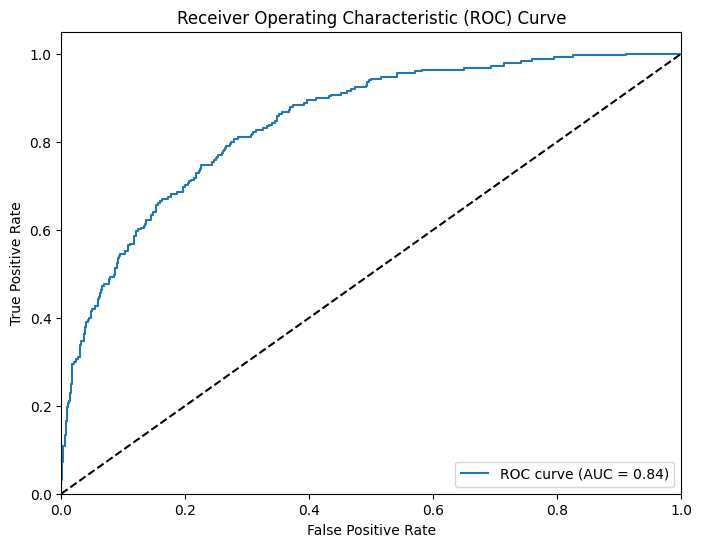

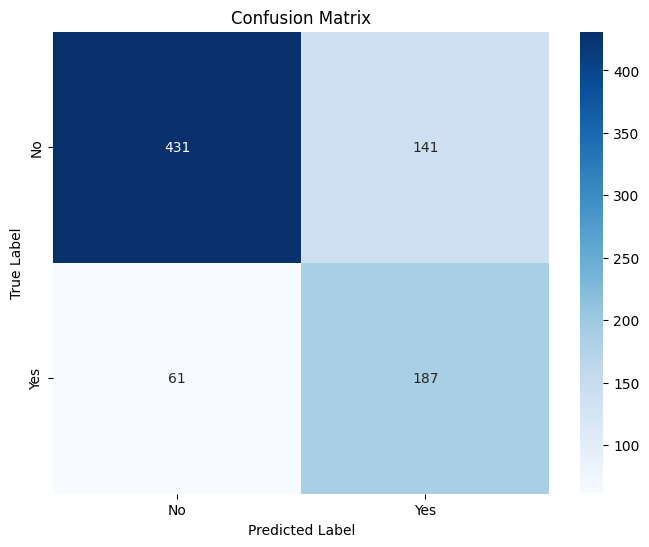

Evaluating for language: Bengali
26/26 [==============================] - 12s 434ms/step
Accuracy: 0.7493917274939172
F1 Score: 0.7643020594965676
AUC: 0.8354464158641302
Results for Bengali saved successfully.


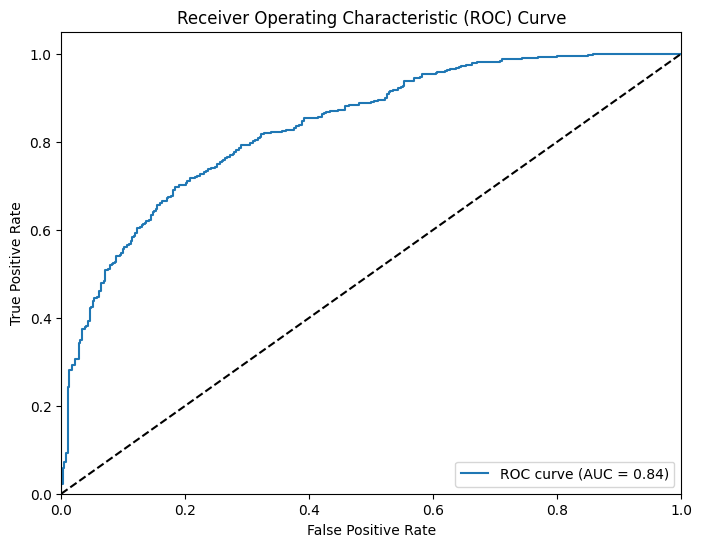

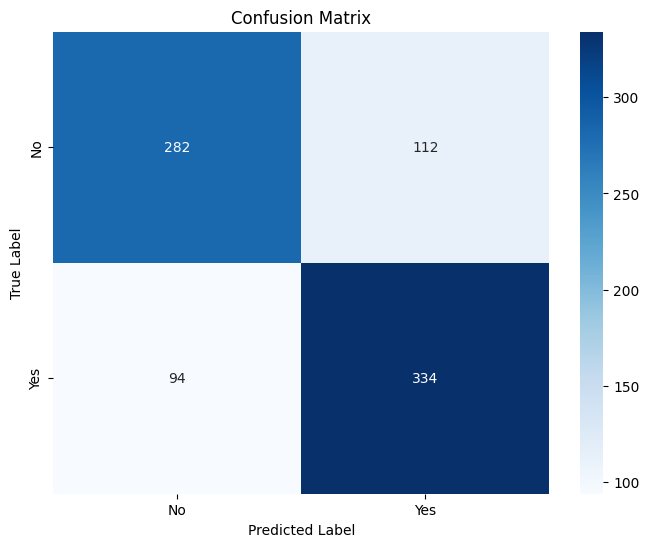

In [ ]:
def load_spectrogram_image(filename, spectrogram_path):
    img_path = os.path.join(spectrogram_path, filename.replace('.wav', '_spectrogram.png'))
    img = load_img(img_path, color_mode="grayscale", target_size=(100, 100))
    img_array = img_to_array(img)
    return img_array / 255.0

languages = ["Bhojpuri", "Gujarati", "Haryanvi", "Hindi", "Kannada", "Malayalam", "Odia", "Punjabi", "Tamil", "Bengali"]

def load_data(language):
    train_annotations_path = f'/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_train.csv'
    test_annotations_path = f'/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_test.csv'
    spectrogram_train_path = f"/content/drive/MyDrive/adima/Spectrogram/{language}/train"
    spectrogram_test_path = f"/content/drive/MyDrive/adima/Spectrogram/{language}/test"

    train_annotations = pd.read_csv(train_annotations_path)
    test_annotations = pd.read_csv(test_annotations_path)

    X_train = np.array([load_spectrogram_image(filename, spectrogram_train_path) for filename in train_annotations['filename']])
    y_train = np.array(train_annotations['label'].map({'Yes': 1, 'No': 0}))
    X_test = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
    y_test = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

    return X_train, y_train, X_test, y_test

    # Define the CNN model
cnn_model_cross = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model_cross.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model_cross.summary()


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model for each language's data
for language in languages:
    print(f"Training for language: {language}")
    X_train, y_train, X_test, y_test = load_data(language)
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    # Train the model with early stopping
    history = cnn_model_cross.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
    X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)
    history = cnn_model_cross.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Save the trained model
model_path = "/content/drive/MyDrive/adima/trained_model_crosslingual_CNN100.h5"
cnn_model_cross.save(model_path)
print("Model saved successfully.")

def load_data(language):
    train_annotations_path = f'/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_train.csv'
    test_annotations_path = f'/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_test.csv'
    spectrogram_train_path = f"/content/drive/MyDrive/adima/Spectrogram/{language}/train"
    spectrogram_test_path = f"/content/drive/MyDrive/adima/Spectrogram/{language}/test"

    train_annotations = pd.read_csv(train_annotations_path)
    test_annotations = pd.read_csv(test_annotations_path)

    X_train = np.array([load_spectrogram_image(filename, spectrogram_train_path) for filename in train_annotations['filename']])
    y_train = np.array(train_annotations['label'].map({'Yes': 1, 'No': 0}))
    X_test = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
    y_test = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

    return X_train, y_train, X_test, y_test, test_annotations

languages = ["Bhojpuri", "Gujarati", "Haryanvi", "Hindi", "Kannada", "Malayalam", "Odia", "Punjabi", "Tamil", "Bengali"]

# Load the saved model
model_path = "/content/drive/MyDrive/adima/trained_model_crosslingual_CNN1.h5"
loaded_model = load_model(model_path)

# Evaluate the model on test data for all languages
for language in languages:
    print(f"Evaluating for language: {language}")
    X_test_lang, y_test_lang, _, _, test_annotations_lang = load_data(language)

    # Evaluate the model
    y_pred_proba = loaded_model.predict(X_test_lang)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_lang, y_pred)
    f1 = f1_score(y_test_lang, y_pred)
    auc = roc_auc_score(y_test_lang, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test_lang, y_pred_proba)
    conf_matrix = confusion_matrix(y_test_lang, y_pred)

    # Print evaluation metrics
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")

    # Create a DataFrame with filenames, true labels, and predicted labels
    results_data = []

    for filename, true_label, pred_label in zip(test_annotations_lang['filename'], y_test_lang, y_pred.flatten()):
        if filename in test_annotations_lang['filename'].values:  # Check if the filename is in test_annotations_lang
            results_data.append({'Filename': f"{filename}_{language}", 'True Label': true_label, 'Predicted Label': pred_label})

    results_df = pd.DataFrame(results_data)

    # Save the DataFrame to a CSV file
    results_csv_path = f"/content/drive/MyDrive/adima/test_results_CNN_{language}.csv"
    results_df.to_csv(results_csv_path, index=False)

    print(f"Results for {language} saved successfully.")

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')  # Include AUC value in the label
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(language):
    train_annotations_path = f'/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_train.csv'
    test_annotations_path = f'/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_test.csv'
    spectrogram_train_path = f"/content/drive/MyDrive/adima/Spectrogram/{language}/train"
    spectrogram_test_path = f"/content/drive/MyDrive/adima/Spectrogram/{language}/test"

    train_annotations = pd.read_csv(train_annotations_path)
    test_annotations = pd.read_csv(test_annotations_path)

    X_train = np.array([load_spectrogram_image(filename, spectrogram_train_path) for filename in train_annotations['filename']])
    y_train = np.array(train_annotations['label'].map({'Yes': 1, 'No': 0}))
    X_test = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
    y_test = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

    return X_train, y_train, X_test, y_test, test_annotations

languages = ["Bhojpuri", "Gujarati", "Haryanvi", "Hindi", "Kannada", "Malayalam", "Odia", "Punjabi", "Tamil", "Bengali"]

# Load the saved model
model_path = "/content/drive/MyDrive/adima/trained_model_crosslingual_CNN1.h5"
loaded_model = load_model(model_path)

# Load and preprocess test data for all languages
X_test_all, y_test_all = [], []

for language in languages:
    X_test_lang, y_test_lang, _, _, test_annotations_lang = load_data(language)
    X_test_all.append(X_test_lang)
    y_test_all.append(y_test_lang)

# Combine test data for all languages
X_test = np.concatenate(X_test_all)
y_test = np.concatenate(y_test_all)

# Evaluate the model on test data
y_pred_proba = loaded_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")

print("Results saved successfully.")

254/254 [==============================] - 128s 503ms/step
Accuracy: 0.7520915354330708
F1 Score: 0.7356683720320084
AUC: 0.8458486514705319
Results saved successfully.


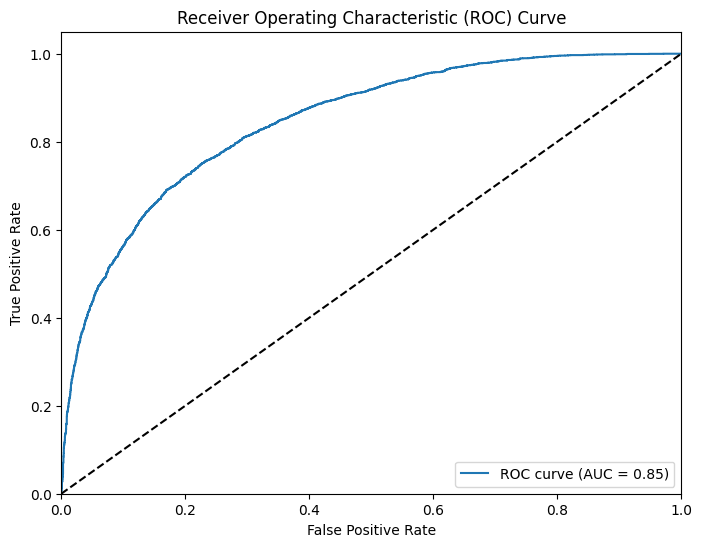

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

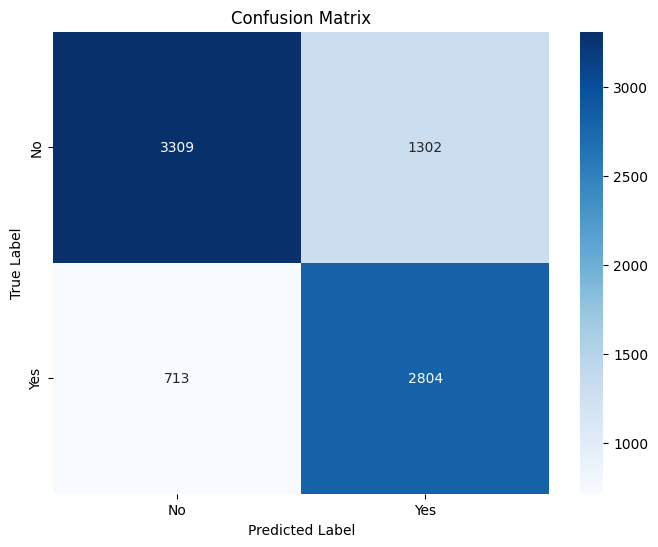

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##LNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models, layers
from kerasncp.tf import LTCCell
from tensorflow.keras.layers import RNN
from tensorflow.keras import models, layers, preprocessing
from ncps.wirings import AutoNCP
from ncps.tf import LTC
import tensorflow as tf
from ncps import wirings
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint
import kerasncp as kncp
from kerasncp.tf import LTCCell
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing import sequence, text

In [ ]:
languages = ["Bhojpuri", "Gujarati", "Haryanvi", "Hindi", "Kannada", "Malayalam", "Odia", "Punjabi", "Tamil", "Bengali"]

from sklearn.preprocessing import LabelEncoder

def load_text_data(language):
    train_annotation_path = f'/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_train.csv'
    test_annotation_path = f'/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_test.csv'
    text_path = f'/content/drive/MyDrive/adima/audios-001/Transcriptions/transcription_{language}.csv'

    train_annotation_data = pd.read_csv(train_annotation_path)
    test_annotation_data = pd.read_csv(test_annotation_path)
    text_data = pd.read_csv(text_path)

    merged_train_data = pd.merge(train_annotation_data, text_data, left_on='filename', right_on='File Name', how='inner')
    merged_train_data = merged_train_data[['Transcription', 'label']]

    merged_test_data = pd.merge(test_annotation_data, text_data, left_on='filename', right_on='File Name', how='inner')
    merged_test_data = merged_test_data[['Transcription', 'label']]

    X_train_text = merged_train_data['Transcription'].values
    y_train = merged_train_data['label'].values

    X_test_text = merged_test_data['Transcription'].values
    y_test = merged_test_data['label'].values

    tokenizer = text.Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(X_train_text)

    X_train_seq = tokenizer.texts_to_sequences(X_train_text)
    X_test_seq = tokenizer.texts_to_sequences(X_test_text)

    max_len = 100
    X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
    X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)

    label_encoder = LabelEncoder()
    label_encoder.fit(y_train)  # Ensure consistent label encoding across all languages

    return X_train_pad, X_test_pad, y_train, y_test, tokenizer, label_encoder, test_annotation_data

In [ ]:
X_train_all, X_test_all, y_train_all, y_test_all = [], [], [], []
tokenizers = {}
label_encoders = {}

In [ ]:
for language in languages:
    X_train, X_test, y_train, y_test, tokenizer, label_encoder,_ = load_text_data(language)
    X_train_all.append(X_train)
    X_test_all.append(X_test)
    y_train_all.append(y_train)
    y_test_all.append(y_test)
    tokenizers[language] = tokenizer
    label_encoders[language] = label_encoder

In [ ]:
max_words = 1000000  # Maximum number of words to tokenize
max_len = 100  # Maximum length of each sequence

In [ ]:
# Combine data for all languages
X_train = np.concatenate(X_train_all)
X_test = np.concatenate(X_test_all)
y_train = np.concatenate(y_train_all)
y_test = np.concatenate(y_test_all)

In [ ]:
# Encode labels for testing data
y_test_encoded = np.concatenate([label_encoders[language].transform(y_test_all[i]) for i, language in enumerate(languages)])
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Define the LTC cell
wiring = AutoNCP(100, 25)
rnn_cell = LTCCell(wiring)

# Define the model
lnn_model_cross = models.Sequential([
    layers.Embedding(max_words, 32, input_length=max_len),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.Conv1D(64, 3, activation='relu'),
    layers.Conv1D(64, 3, activation='relu'),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Reshape((1, -1)),  # Reshape for LSTM
    layers.RNN(rnn_cell, return_sequences=True),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])# Compile the model
lnn_model_cross.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lnn_model_cross.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           32000000  
                                                                 
 conv1d (Conv1D)             (None, 98, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 64)            6208      
                                                                 
 conv1d_2 (Conv1D)           (None, 45, 64)            12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 43, 64)            12352     
                                                      

In [ ]:
# Convert class labels to integer indices
label_dict = {label: i for i, label in enumerate(np.unique(y_train))}
y_train_indices = np.array([label_dict[label] for label in y_train])

In [ ]:
# Fit the model with early stopping
history = lnn_model_cross.fit(X_train, y_train_encoded,
                              epochs=20,
                              batch_size=32,
                              validation_data=(X_test, y_test_encoded))
# Fit the model with early stopping
history = lnn_model_cross.fit(X_test, y_test_encoded,
                              epochs=20,
                              batch_size=32,
                              validation_data=(X_train, y_train_encoded))

Epoch 1/20
170/170 [==============================] - 217s 1s/step - loss: 0.6769 - accuracy: 0.5676 - val_loss: 0.6281 - val_accuracy: 0.6546
Epoch 2/20
170/170 [==============================] - 195s 1s/step - loss: 0.6115 - accuracy: 0.6712 - val_loss: 0.6132 - val_accuracy: 0.6550
Epoch 3/20
170/170 [==============================] - 206s 1s/step - loss: 0.5683 - accuracy: 0.7064 - val_loss: 0.6150 - val_accuracy: 0.6604
Epoch 4/20
170/170 [==============================] - 201s 1s/step - loss: 0.5296 - accuracy: 0.7372 - val_loss: 0.6294 - val_accuracy: 0.6608
Epoch 5/20
170/170 [==============================] - 210s 1s/step - loss: 0.5006 - accuracy: 0.7532 - val_loss: 0.6435 - val_accuracy: 0.6587
Epoch 6/20
170/170 [==============================] - 215s 1s/step - loss: 0.4732 - accuracy: 0.7654 - val_loss: 0.6717 - val_accuracy: 0.6608
Epoch 7/20
170/170 [==============================] - 201s 1s/step - loss: 0.4417 - accuracy: 0.7799 - val_loss: 0.6635 - val_accuracy: 0.6621

In [ ]:
# Define the file path to save the model
model_path = '/content/drive/MyDrive/adima/model3_text_LNN_CrossLingual20.h5'

# Save the model
lnn_model_cross.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate the model
y_pred_LNN = lnn_model_cross.predict(X_test)

75/75 [==============================] - 4s 55ms/step


In [ ]:
y_pred_LNN = (y_pred_LNN > 0.5).astype(int)

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test_encoded, y_pred_LNN)
f1 = f1_score(y_test_encoded, y_pred_LNN)
conf_matrix = confusion_matrix(y_test_encoded, y_pred_LNN)

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.8573216520650814
F1 Score: 0.8466367713004485


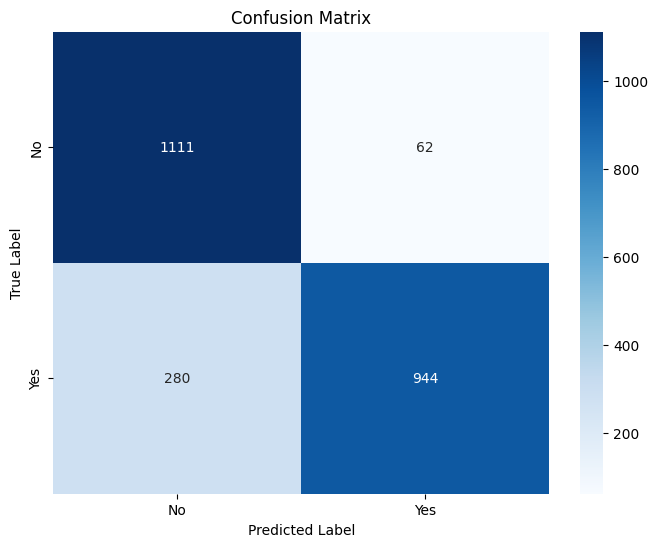

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix as heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

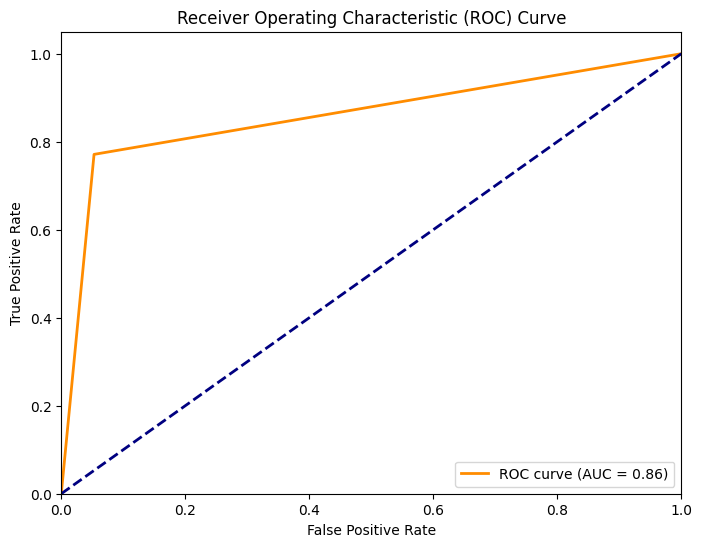

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_LNN)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def load_text_data(language):
    annotation_path = f'/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_test.csv'
    text_path = f'/content/drive/MyDrive/adima/audios-001/Transcriptions/transcription_{language}.csv'

    annotation_data = pd.read_csv(annotation_path)
    text_data = pd.read_csv(text_path)
    test_annotations = pd.read_csv(annotation_path)

    merged_data = pd.merge(annotation_data, text_data, left_on='filename', right_on='File Name', how='inner')
    merged_data = merged_data[['Transcription', 'label']]

    X_text = merged_data['Transcription'].values
    y = merged_data['label'].values

    label_encoder = LabelEncoder()
    label_encoder.fit(y)  # Ensure consistent label encoding across all languages

    X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

    tokenizer = text.Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(X_train_text)
    X_train_seq = tokenizer.texts_to_sequences(X_train_text)
    X_test_seq = tokenizer.texts_to_sequences(X_test_text)

    max_len = 100
    X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
    X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)

    return X_train_pad, X_test_pad, y_train, y_test, tokenizer, label_encoder, test_annotations

languages = ["Bhojpuri", "Gujarati", "Haryanvi", "Hindi", "Kannada", "Malayalam", "Odia", "Punjabi", "Tamil", "Bengali"]

Evaluating for language: Bhojpuri
2/2 [==============================] - 0s 132ms/step
Accuracy: 0.49019607843137253
F1 Score: 0.5937499999999999
AUC: 0.475
Results for Bhojpuri saved successfully.


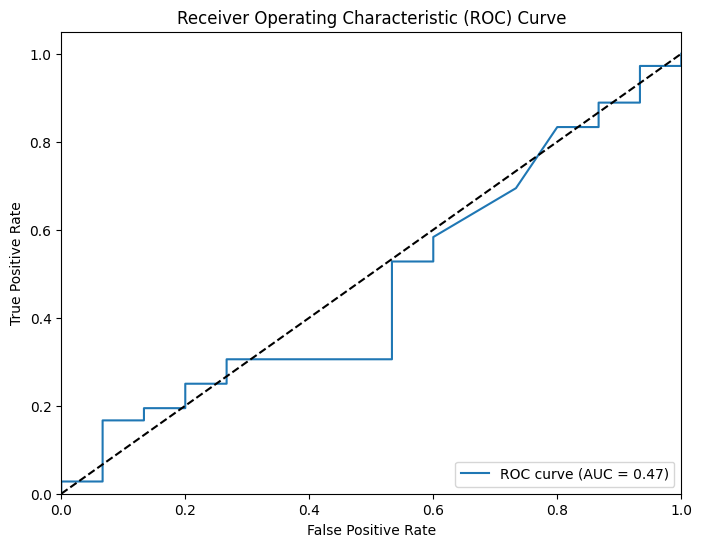

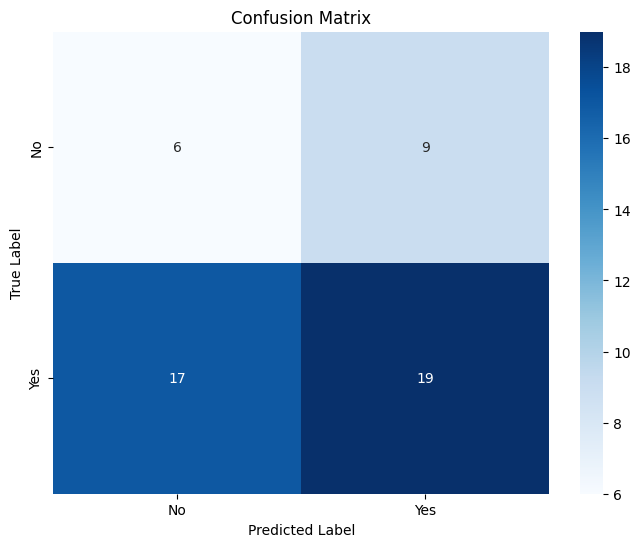

Evaluating for language: Gujarati
2/2 [==============================] - 0s 46ms/step
Accuracy: 0.7346938775510204
F1 Score: 0.6285714285714286
AUC: 0.8102040816326531
Results for Gujarati saved successfully.


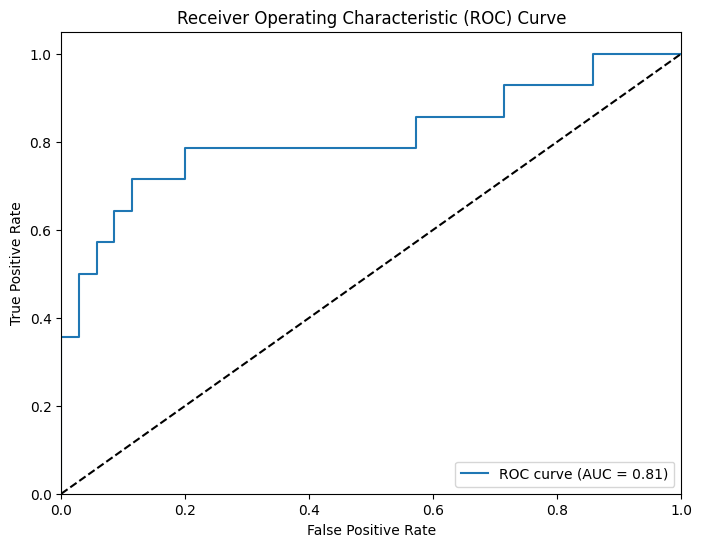

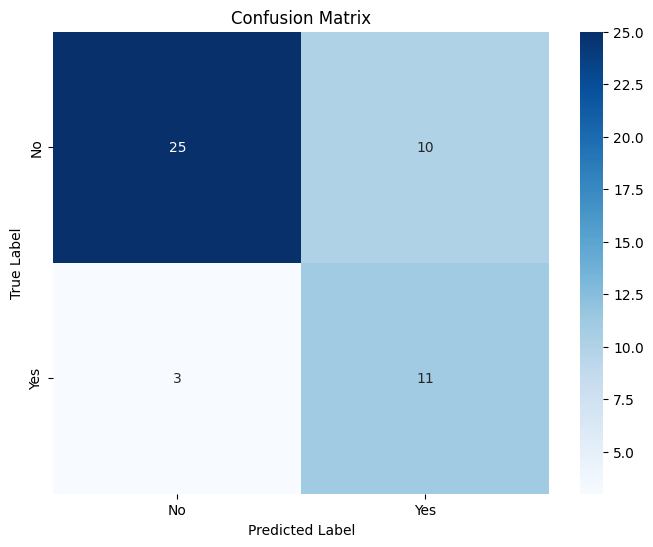

Evaluating for language: Haryanvi
2/2 [==============================] - 0s 36ms/step
Accuracy: 0.6226415094339622
F1 Score: 0.6428571428571429
AUC: 0.7327586206896552
Results for Haryanvi saved successfully.


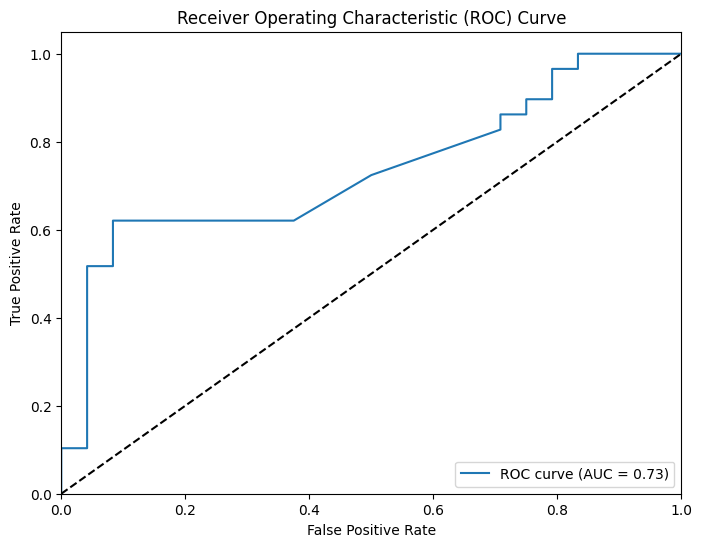

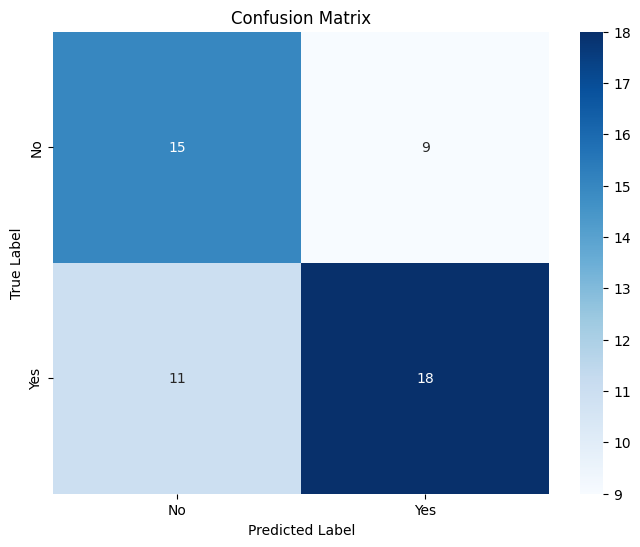

Evaluating for language: Hindi
2/2 [==============================] - 0s 50ms/step
Accuracy: 0.5714285714285714
F1 Score: 0.6
AUC: 0.6217948717948717
Results for Hindi saved successfully.


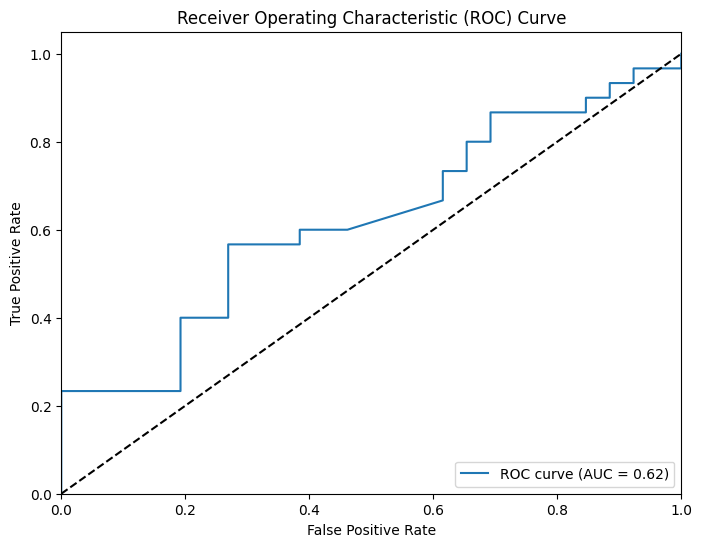

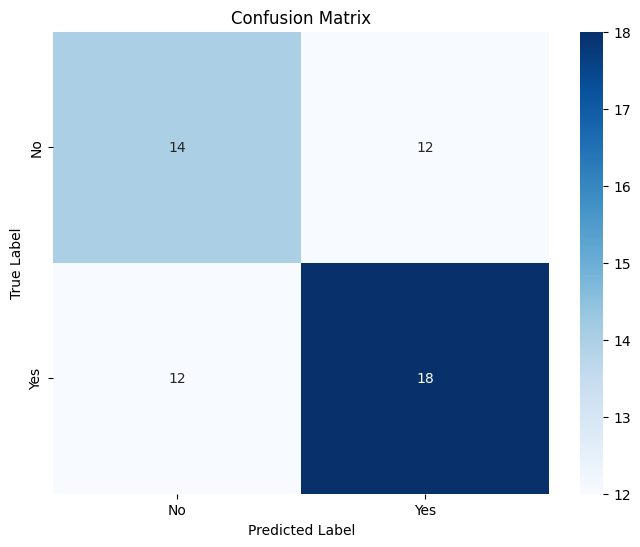

Evaluating for language: Kannada
2/2 [==============================] - 0s 25ms/step
Accuracy: 0.4444444444444444
F1 Score: 0.16666666666666669
AUC: 0.43015873015873013
Results for Kannada saved successfully.


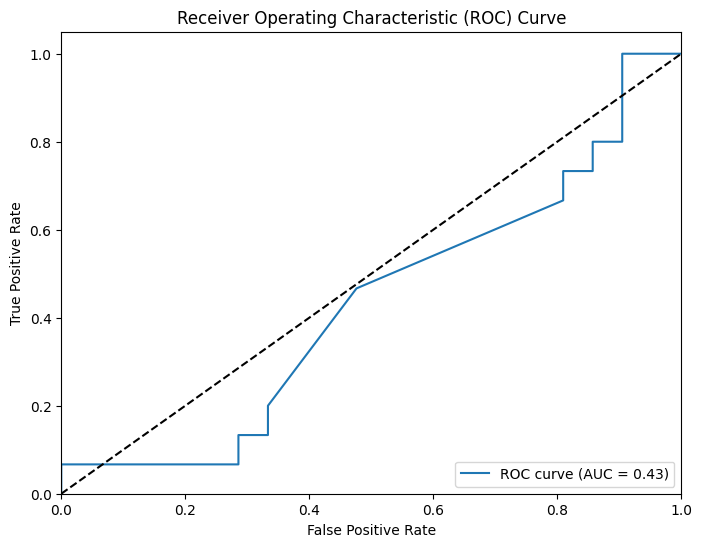

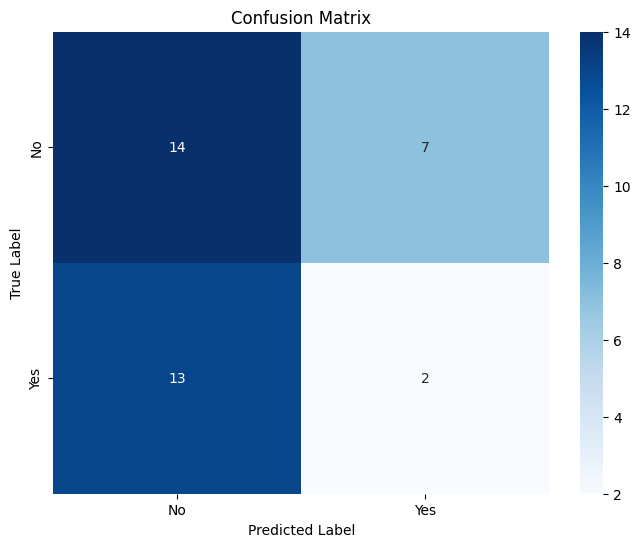

Evaluating for language: Malayalam
2/2 [==============================] - 0s 24ms/step
Accuracy: 0.6923076923076923
F1 Score: 0.14285714285714288
AUC: 0.41558441558441556
Results for Malayalam saved successfully.


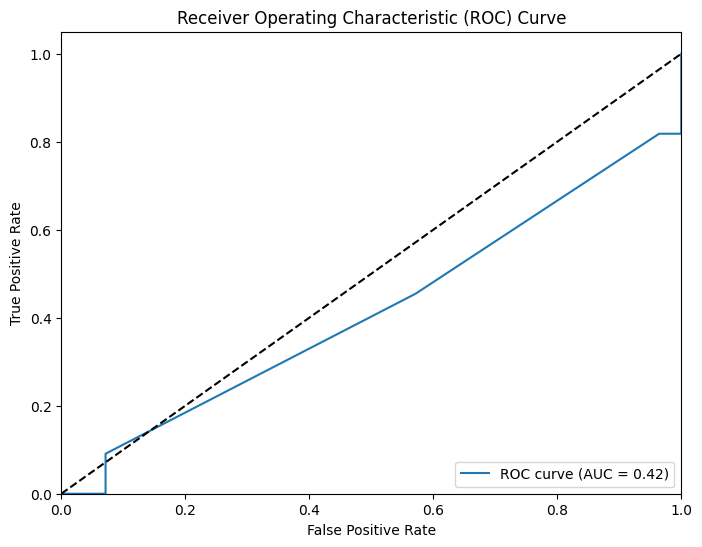

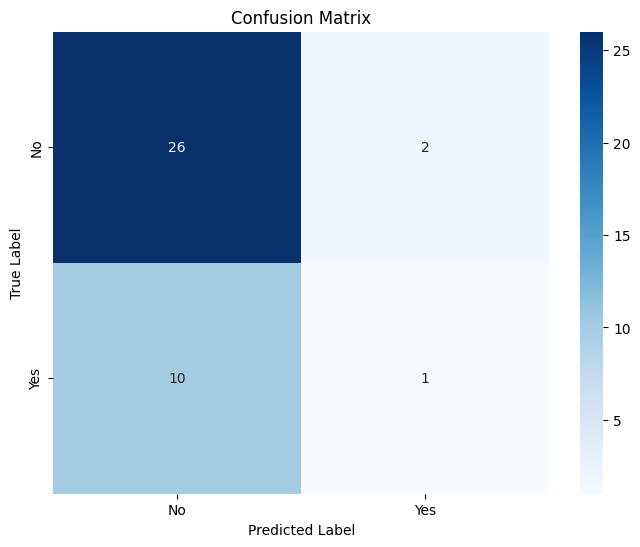

Evaluating for language: Odia
2/2 [==============================] - 0s 22ms/step
Accuracy: 0.46153846153846156
F1 Score: 0.16
AUC: 0.41447368421052627
Results for Odia saved successfully.


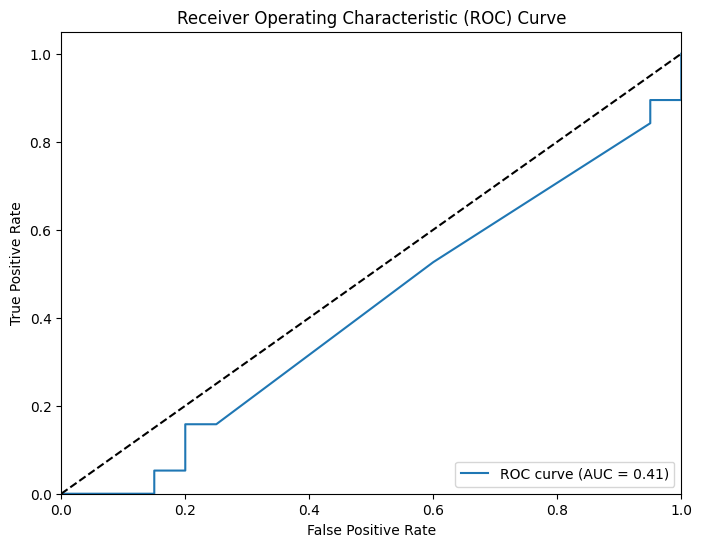

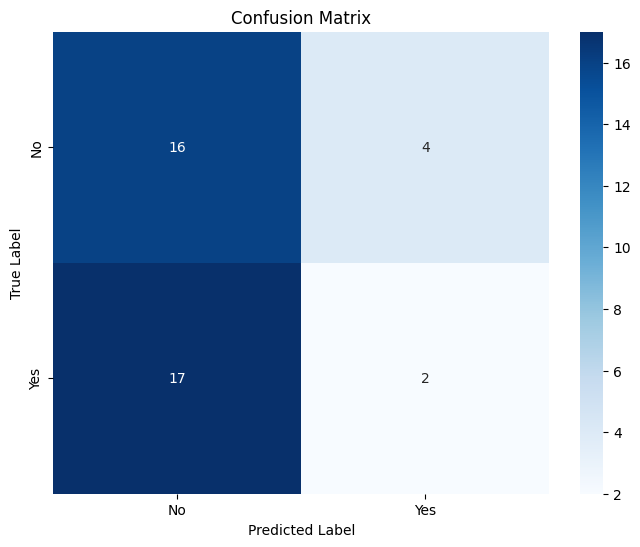

Evaluating for language: Punjabi
3/3 [==============================] - 0s 43ms/step
Accuracy: 0.6923076923076923
F1 Score: 0.761904761904762
AUC: 0.7134502923976609
Results for Punjabi saved successfully.


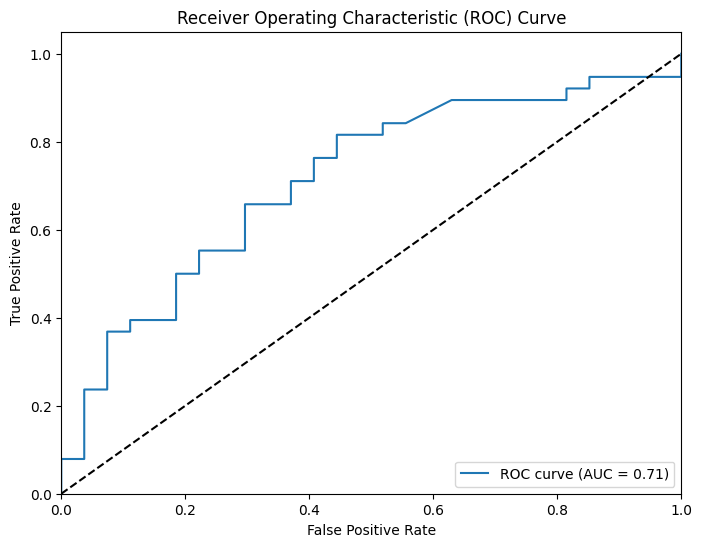

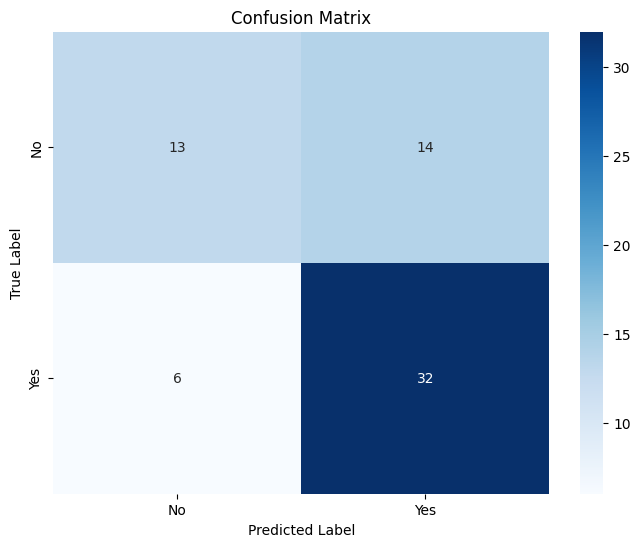

Evaluating for language: Tamil
2/2 [==============================] - 0s 26ms/step
Accuracy: 0.4878048780487805
F1 Score: 0.22222222222222224
AUC: 0.34656084656084657
Results for Tamil saved successfully.


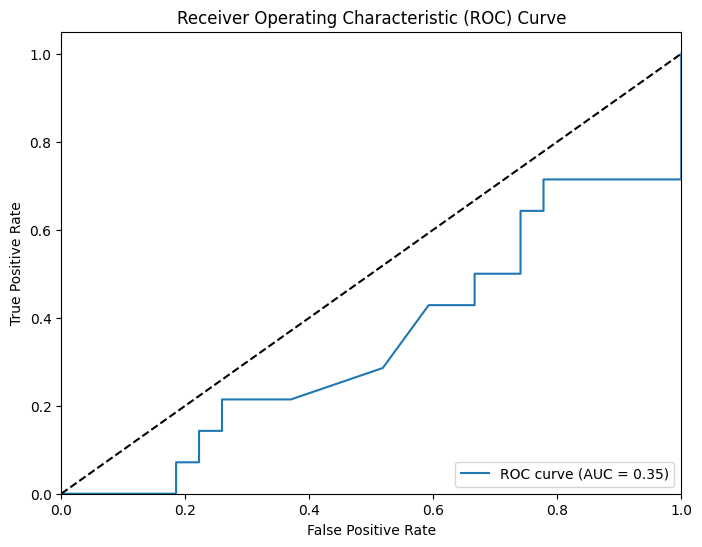

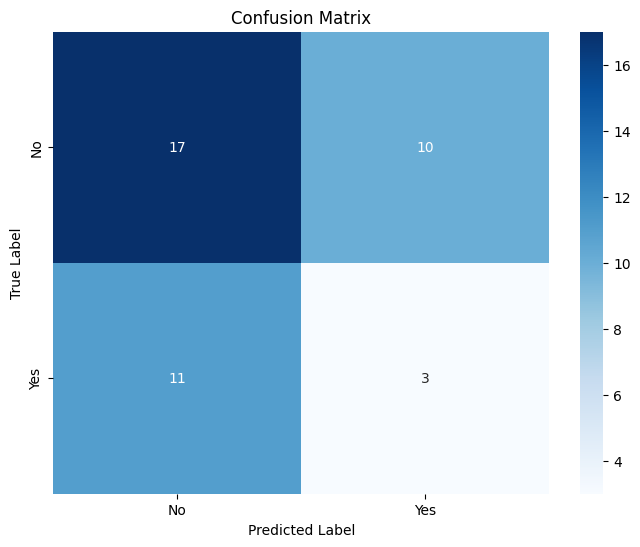

Evaluating for language: Bengali
2/2 [==============================] - 0s 48ms/step
Accuracy: 0.5740740740740741
F1 Score: 0.5818181818181818
AUC: 0.6046176046176046
Results for Bengali saved successfully.


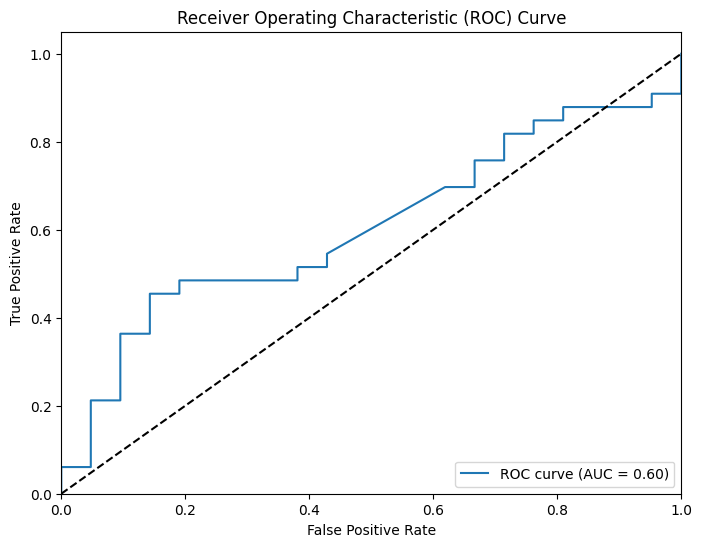

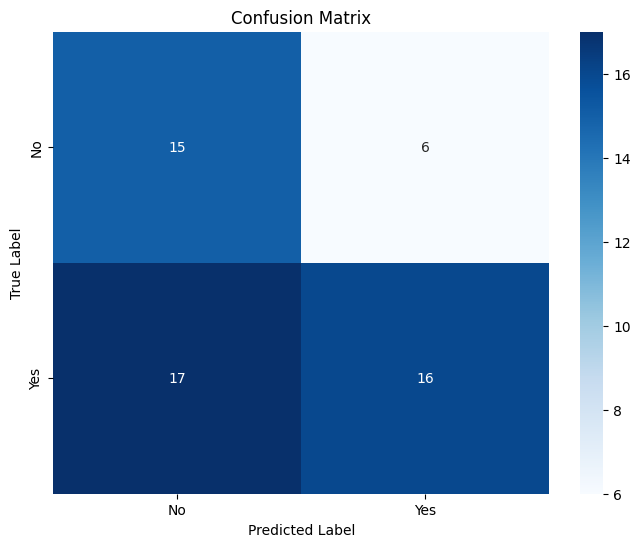

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on test data for all languages
for language in languages:
    print(f"Evaluating for language: {language}")
    _, X_test_lang, _, y_test_lang, _, _, test_annotations_lang = load_text_data(language)

    # Evaluate the model
    y_pred_proba = lnn_model_cross.predict(X_test_lang)
    y_pred = (y_pred_proba > 0.5).astype(int)
    y_test_lang = np.array([1 if label == "Yes" else 0 for label in y_test_lang])

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_lang, y_pred)
    f1 = f1_score(y_test_lang, y_pred)
    auc = roc_auc_score(y_test_lang, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test_lang, y_pred_proba)
    conf_matrix = confusion_matrix(y_test_lang, y_pred)

    # Print evaluation metrics
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")

  # Create a DataFrame with filenames, true labels, and predicted labels
    results_data = []

    for filename, true_label, pred_label in zip(test_annotations_lang['filename'], y_test_lang, y_pred.flatten()):
        if filename in test_annotations_lang['filename'].values:  # Check if the filename is in test_annotations_lang
            results_data.append({'Filename': f"{filename}_{language}", 'True Label': true_label, 'Predicted Label': pred_label})

    results_df = pd.DataFrame(results_data)


    # Save the DataFrame to a CSV file
    results_csv_path = f"/content/drive/MyDrive/adima/test_results_LNN_{language}.csv"
    results_df.to_csv(results_csv_path, index=False)

    print(f"Results for {language} saved successfully.")

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')  # Include AUC value in the label
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

## FUSION

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
model_path = "/content/drive/MyDrive/adima/trained_model_crosslingual_CNN1.h5"
cnn_model = load_model(model_path)

# Load predictions from CNN model
cnn_train_predictions = cnn_model.predict(X_train_spectrogram)
cnn_test_predictions = cnn_model.predict(X_test_spectrogram)

12/12 [==============================] - 7s 552ms/step


In [ ]:
# Load predictions from LSTM model
lstm_train_predictions = lnn_model_cross.predict(X_train)
lstm_test_predictions = lnn_model_cross.predict(X_test)

75/75 [==============================] - 6s 72ms/step


In [ ]:
# Calculate accuracies
cnn_accuracy = accuracy_score(y_test_spectrogram, np.round(cnn_test_predictions))
lstm_accuracy = accuracy_score(y_test_encoded, np.round(lstm_test_predictions))

# Assign weights based on accuracies
total_accuracy = cnn_accuracy + lstm_accuracy
cnn_weight = cnn_accuracy / total_accuracy
lstm_weight = lstm_accuracy / total_accuracy

print("CNN Accuracy:", cnn_accuracy)
print("LSTM Accuracy:", lstm_accuracy)
print("Assigned weights - CNN:", cnn_weight, "LSTM:", lstm_weight)

CNN Accuracy: 0.7675675675675676
LSTM Accuracy: 0.8573216520650814
Assigned weights - CNN: 0.47238147579137574 LSTM: 0.5276185242086242


In [ ]:
# Combine predictions selectively where both models have predictions
train_combined_predictions = []
for i in range(len(y_train)):
    if i < len(cnn_train_predictions) and i < len(lstm_train_predictions):
        combined_pred = np.round((cnn_weight * cnn_train_predictions[i]) + (lstm_weight * lstm_train_predictions[i]))
    elif i < len(cnn_train_predictions):
        combined_pred = np.round(cnn_weight * cnn_train_predictions[i])
    else:
        combined_pred = np.round(lstm_weight * lstm_train_predictions[i])
    train_combined_predictions.append(combined_pred)

# Combine predictions for test data similarly
test_combined_predictions = []
for i in range(len(y_test)):
    if i < len(cnn_test_predictions) and i < len(lstm_test_predictions):
        combined_pred = np.round((cnn_weight * cnn_test_predictions[i]) + (lstm_weight * lstm_test_predictions[i]))
    elif i < len(cnn_test_predictions):
        combined_pred = np.round(cnn_weight * cnn_test_predictions[i])
    else:
        combined_pred = np.round(lstm_weight * lstm_test_predictions[i])
    test_combined_predictions.append(combined_pred)

In [ ]:
print(train_combined_predictions)
print(test_combined_predictions)

[array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=f

In [ ]:
# Convert true labels to match the format of predicted labels
y_test = np.array([1 if label == 'Yes' else 0 for label in y_test])
print("Unique values in y_train_pred_format:", np.unique(y_test))

Unique values in y_train_pred_format: [0 1]


In [ ]:
# Calculate accuracy and other metrics
train_accuracy = accuracy_score(y_train_encoded, train_combined_predictions)
test_accuracy = accuracy_score(y_test_encoded, test_combined_predictions)
train_f1_score = f1_score(y_train_encoded, train_combined_predictions)
test_f1_score = f1_score(y_test_encoded, test_combined_predictions)
train_auc = roc_auc_score(y_train_encoded, train_combined_predictions)
test_auc = roc_auc_score(y_test_encoded, test_combined_predictions)

print("Training Accuracy:", train_accuracy)
print("Training F1 Score:", train_f1_score)
print("Training AUC:", train_auc)
print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)
print("Testing AUC:", test_auc)

Training Accuracy: 0.7469590858827866
Training F1 Score: 0.6854524627720504
Training AUC: 0.7486706232744191
Testing Accuracy: 0.7747183979974969
Testing F1 Score: 0.725609756097561
Testing AUC: 0.7788789428815005


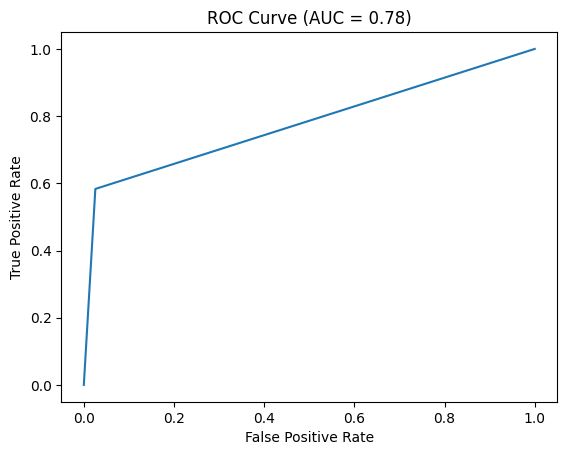

In [ ]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_combined_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.2f})'.format(test_auc))  # Annotate AUC in the plot title
plt.show()

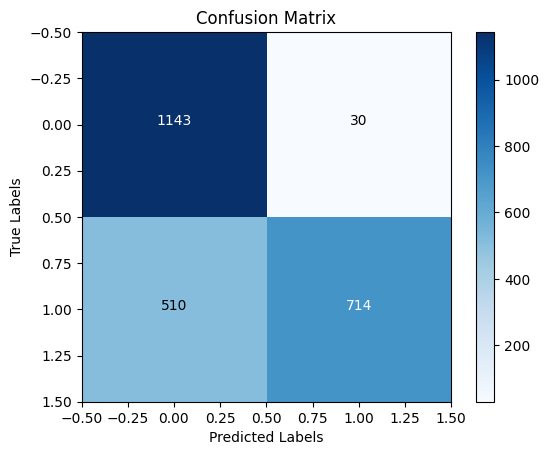

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, test_combined_predictions)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

# Failed Fusion attempts ☠

## Fusion

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# Paths to LNN and CNN result files
lnn_results_paths = [f"/content/drive/MyDrive/adima/test_results_LNN_{lang}.csv" for lang in languages]
cnn_results_paths = [f"/content/drive/MyDrive/adima/test_results_CNN_{lang}.csv" for lang in languages]

# Read LNN and CNN results for all languages
lnn_dfs = [pd.read_csv(path) for path in lnn_results_paths]
cnn_dfs = [pd.read_csv(path) for path in cnn_results_paths]

# Combine LNN and CNN DataFrames for all languages
lnn_combined = pd.concat(lnn_dfs)
cnn_combined = pd.concat(cnn_dfs)

# Merge LNN and CNN DataFrames based on 'Filename'
merged_dfs = []
for lnn_df, cnn_df in zip(lnn_dfs, cnn_dfs):
    # Only include files present in both DataFrames
    common_files = set(lnn_df['Filename']).intersection(cnn_df['Filename'])

    # Filter DataFrames to include only common files
    lnn_df_filtered = lnn_df[lnn_df['Filename'].isin(common_files)]
    cnn_df_filtered = cnn_df[cnn_df['Filename'].isin(common_files)]

    # Merge the filtered DataFrames
    merged_df = pd.merge(lnn_df_filtered, cnn_df_filtered, on='Filename', suffixes=('_LNN', '_CNN'))

    # Append merged DataFrame to the list
    merged_dfs.append(merged_df)

# Concatenate all merged DataFrames into a single DataFrame
merged_result = pd.concat(merged_dfs)

In [ ]:
merged_result

,Filename,True Label_LNN,Predicted Label_LNN,True Label_CNN,Predicted Label_CNN
0,Abuse_0.wav_Bhojpuri,1,1,0,0
1,Abuse_3.wav_Bhojpuri,1,0,1,1
2,Abuse_7.wav_Bhojpuri,1,0,1,1
3,Abuse_11.wav_Bhojpuri,0,0,1,1
4,Abuse_14.wav_Bhojpuri,1,0,1,1
...,...,...,...,...,...
49,Abuse_197.wav_Bengali,0,1,1,1
50,Abuse_200.wav_Bengali,1,1,1,1
51,Abuse_201.wav_Bengali,1,0,1,1
52,Abuse_203.wav_Bengali,1,0,0,0


In [ ]:
# Select necessary columns
result_df = merged_df[['Filename', 'True Label_LNN', 'Predicted Label_CNN', 'Predicted Label_LNN']]
result_df.columns = ['File Name', 'True Value', 'CNN Predicted Value', 'LNN Predicted Value']

# Calculate accuracies
cnn_accuracy = 0.7520915354330708
lnn_accuracy = 0.8573216520650814

# Calculate total accuracy
total_accuracy = cnn_accuracy + lnn_accuracy

# Calculate weights
cnn_weight = cnn_accuracy / total_accuracy
lnn_weight = lnn_accuracy / total_accuracy

# Create weights dictionary
weights = {'LNN': lnn_weight, 'CNN': cnn_weight}

In [ ]:
weights

{'LNN': 0.5326920760465471, 'CNN': 0.467307923953453}

In [ ]:
# Calculate weighted average predictions
weighted_avg_predictions = lnn_weight * result_df['LNN Predicted Value'] + cnn_weight * result_df['CNN Predicted Value']

# Scale the predictions by the weights assigned to each model
#weighted_avg_predictions_scaled = (lnn_weight * result_df['LNN Predicted Value'] + cnn_weight * result_df['CNN Predicted Value']) / (lnn_weight + cnn_weight)

# Round the predictions if they are probabilities or continuous scores
weighted_avg_predictions_rounded = (weighted_avg_predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(result_df['True Value'], weighted_avg_predictions_rounded)

# Calculate F1 score
f1 = f1_score(result_df['True Value'], weighted_avg_predictions_rounded)

# Print accuracy and F1 score
print("Accuracy:", accuracy)
print("F1:", f1)

Accuracy: 0.5859213250517599
F1: 0.5495495495495495


In [ ]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(result_df['True Value'], weighted_avg_predictions_rounded)

# Calculate AUC
auc_score = roc_auc_score(result_df['True Value'], weighted_avg_predictions_rounded)

# Calculate confusion matrix
conf_matrix = confusion_matrix(result_df['True Value'], weighted_avg_predictions_rounded)

# Print AUC score
print("AUC Score:", auc_score)

AUC Score: 0.5851481583098977


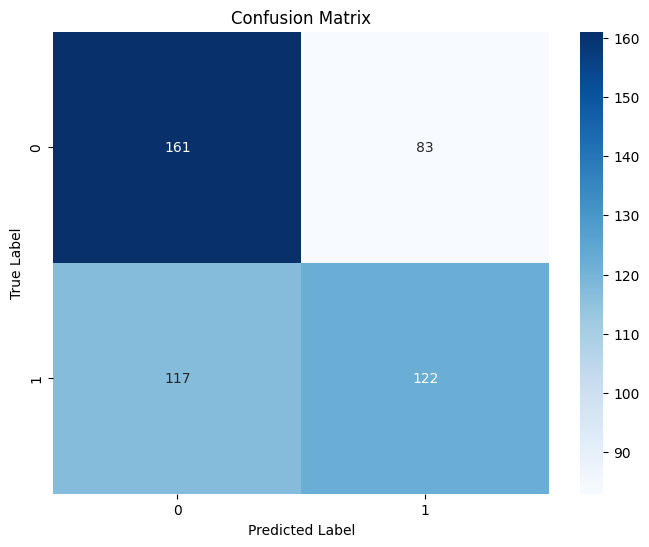

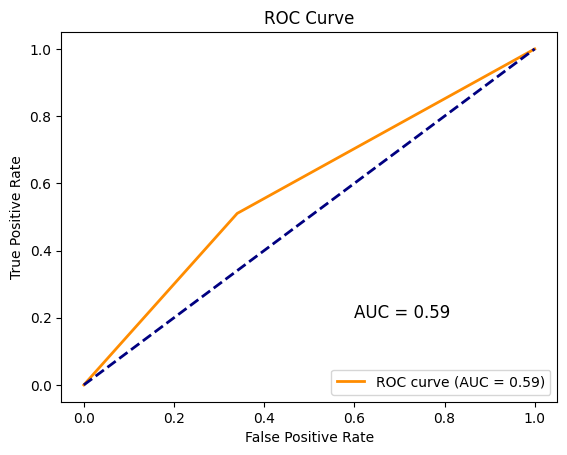

In [ ]:
import seaborn as sns

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.text(0.6, 0.2, f'AUC = {auc_score:.2f}', fontsize=12)
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Paths to LNN and CNN result files
lnn_results_paths = [f"/content/drive/MyDrive/adima/test_results_LNN_{lang}.csv" for lang in languages]
cnn_results_paths = [f"/content/drive/MyDrive/adima/test_results_CNN_{lang}.csv" for lang in languages]

# Read LNN and CNN results for all languages
lnn_dfs = [pd.read_csv(path) for path in lnn_results_paths]
cnn_dfs = [pd.read_csv(path) for path in cnn_results_paths]

# Combine LNN and CNN DataFrames for all languages
lnn_combined = pd.concat(lnn_dfs)
cnn_combined = pd.concat(cnn_dfs)

# Merge LNN and CNN DataFrames based on 'Filename'
merged_df = pd.merge(lnn_combined, cnn_combined, on='Filename', suffixes=('_LNN', '_CNN'), how='inner')

merged_df

,Filename,True Label_LNN,Predicted Label_LNN,True Label_CNN,Predicted Label_CNN
0,Abuse_0.wav_Bhojpuri,1,1,0,0
1,Abuse_3.wav_Bhojpuri,1,0,1,1
2,Abuse_7.wav_Bhojpuri,1,0,1,1
3,Abuse_11.wav_Bhojpuri,0,0,1,1
4,Abuse_14.wav_Bhojpuri,1,0,1,1
...,...,...,...,...,...
478,Abuse_197.wav_Bengali,0,1,1,1
479,Abuse_200.wav_Bengali,1,1,1,1
480,Abuse_201.wav_Bengali,1,0,1,1
481,Abuse_203.wav_Bengali,1,0,0,0


In [ ]:
# Select necessary columns
result_df = merged_df[['Filename', 'True Label_LNN', 'Predicted Label_CNN', 'Predicted Label_LNN']]
result_df.columns = ['File Name', 'True Value', 'CNN Predicted Value', 'LNN Predicted Value']

In [ ]:
# Create a feature matrix X (containing the predicted values from LNN and CNN)
X = result_df[['CNN Predicted Value', 'LNN Predicted Value']]
# Create a target variable y (the true values)
y = result_df['True Value']

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],                # Number of trees in the forest
    'max_depth': [None, 10, 20],                    # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],                # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']        # Number of features to consider when looking for the best split
}

# Create the grid search object
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,                    # 5-fold cross-validation
                           scoring='accuracy',      # Use accuracy as the evaluation metric
                           n_jobs=-1)               # Use all available CPU cores

# Perform grid search on the training data
grid_search.fit(X, y)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions using the best model
ensemble_predictions_tuned = best_model.predict(X)

# Calculate accuracy
accuracy_tuned = accuracy_score(y, ensemble_predictions_tuned)
print("Accuracy (Tuned):", accuracy_tuned)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


KeyboardInterrupt: 

In [ ]:
# Train Random Forest Classifier on the feature matrix X and target variable y
rf_classifier = RandomForestClassifier(max_depth=None,
                                       max_features='auto',
                                       min_samples_leaf=1,
                                       min_samples_split=2,
                                       n_estimators=100)
rf_classifier.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_features='auto')

In [ ]:
ensemble_predictions = rf_classifier.predict(X)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y, ensemble_predictions)

# Calculate F1 score
f1 = f1_score(y, ensemble_predictions)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y, ensemble_predictions)

# Calculate AUC
auc_score = roc_auc_score(y, ensemble_predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y, ensemble_predictions)

print("Accuracy:", accuracy)
print("F1:", f1)

Accuracy: 0.5859213250517599
F1: 0.5495495495495495


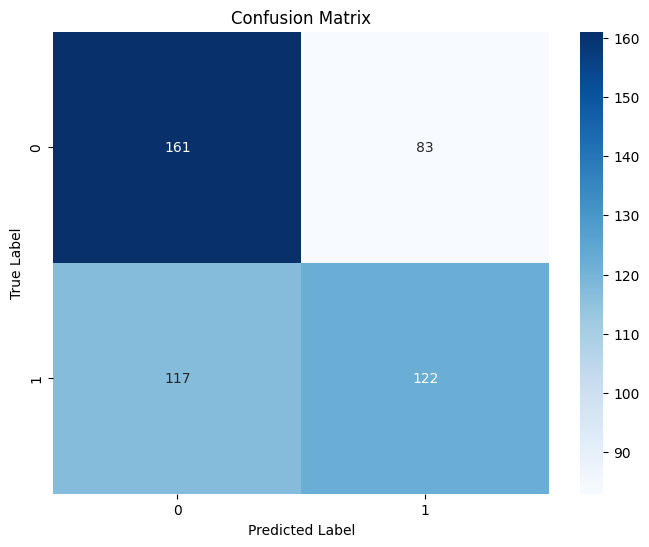

In [ ]:
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

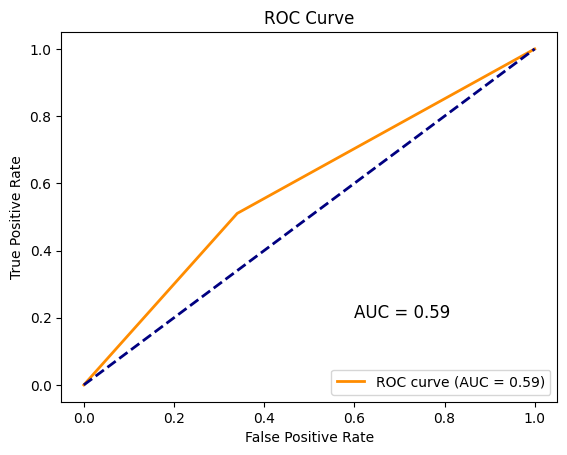

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.text(0.6, 0.2, f'AUC = {auc_score:.2f}', fontsize=12)
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Paths to LNN and CNN result files
lnn_results_paths = [f"/content/drive/MyDrive/adima/test_results_LNN_{lang}.csv" for lang in languages]
cnn_results_paths = [f"/content/drive/MyDrive/adima/test_results_CNN_{lang}.csv" for lang in languages]

# Read LNN and CNN results for all languages
lnn_dfs = [pd.read_csv(path) for path in lnn_results_paths]
cnn_dfs = [pd.read_csv(path) for path in cnn_results_paths]

# Combine LNN and CNN DataFrames for all languages
lnn_combined = pd.concat(lnn_dfs)
cnn_combined = pd.concat(cnn_dfs)

# Merge LNN and CNN DataFrames based on 'Filename'
merged_df = pd.merge(lnn_combined, cnn_combined, on='Filename', suffixes=('_LNN', '_CNN'), how='inner')

# Select necessary columns
result_df = merged_df[['Filename', 'True Label_LNN', 'Predicted Label_CNN', 'Predicted Label_LNN']]
result_df.columns = ['File Name', 'True Value', 'CNN Predicted Value', 'LNN Predicted Value']

# Create a feature matrix X (containing the predicted values from LNN and CNN)
X = result_df[['CNN Predicted Value', 'LNN Predicted Value']]

# Create a target variable y (the true values)
y = result_df['True Value']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train Random Forest Classifier on the training data
rf_classifier = RandomForestClassifier(max_depth=None,
                                       max_features='auto',
                                       min_samples_leaf=1,
                                       min_samples_split=2,
                                       n_estimators=100)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
ensemble_predictions = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, ensemble_predictions)

# Calculate F1 score
f1 = f1_score(y_test, ensemble_predictions)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, ensemble_predictions)

# Calculate AUC
auc_score = roc_auc_score(y_test, ensemble_predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, ensemble_predictions)

print("Accuracy:", accuracy)
print("F1:", f1)
print("AUC:", auc_score)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy: 0.6020408163265306
F1: 0.5411764705882353
AUC: 0.5995833333333334


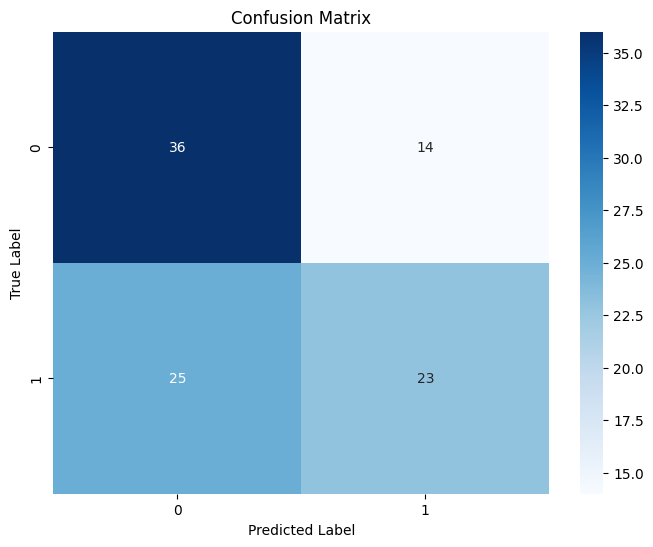

In [ ]:
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

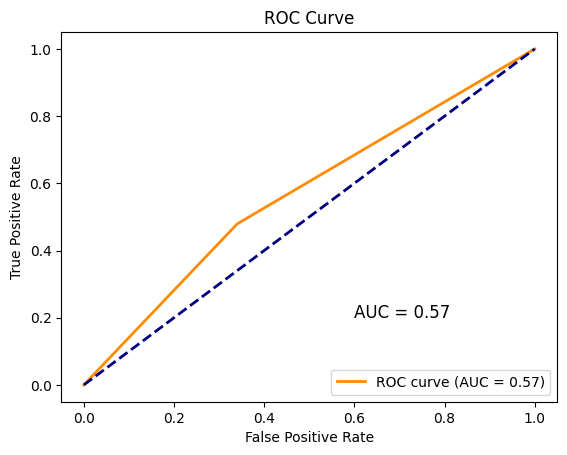

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.text(0.6, 0.2, f'AUC = {auc_score:.2f}', fontsize=12)
plt.legend(loc="lower right")
plt.show()

# Cross Lingual?

## CNN

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
train_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Hindi_train.csv'
test_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Hindi_test.csv'
spectrogram_train_path = '/content/drive/MyDrive/adima/Spectrogram/Hindi/train'
spectrogram_test_path = '/content/drive/MyDrive/adima/Spectrogram/Hindi/test'

In [ ]:
train_annotations = pd.read_csv(train_annotations_path)
test_annotations = pd.read_csv(test_annotations_path)

In [ ]:
def load_spectrogram_image(filename, spectrogram_path):
    img_path = os.path.join(spectrogram_path, filename.replace('.wav', '_spectrogram.png'))
    img = load_img(img_path, color_mode="grayscale", target_size=(100, 100))
    img_array = img_to_array(img)
    return img_array / 255.0

In [ ]:
X_train_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_train_path) for filename in train_annotations['filename']])
y_train_spectrogram = np.array(train_annotations['label'].map({'Yes': 1, 'No': 0}))
X_test_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
y_test_spectrogram = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

In [ ]:
cnn_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 256)       0

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = cnn_model.fit(X_train_spectrogram, y_train_spectrogram, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
21/21 [==============================] - 50s 2s/step - loss: 0.7453 - accuracy: 0.4810 - val_loss: 0.6714 - val_accuracy: 0.6121
Epoch 2/50
21/21 [==============================] - 38s 2s/step - loss: 0.6953 - accuracy: 0.4916 - val_loss: 0.6821 - val_accuracy: 0.6121
Epoch 3/50
21/21 [==============================] - 41s 2s/step - loss: 0.6890 - accuracy: 0.5282 - val_loss: 0.6818 - val_accuracy: 0.7091
Epoch 4/50
21/21 [==============================] - 52s 3s/step - loss: 0.6788 - accuracy: 0.5571 - val_loss: 0.6347 - val_accuracy: 0.6061
Epoch 5/50
21/21 [==============================] - 38s 2s/step - loss: 0.6367 - accuracy: 0.6454 - val_loss: 0.5853 - val_accuracy: 0.6606
Epoch 6/50
21/21 [==============================] - 43s 2s/step - loss: 0.6641 - accuracy: 0.6073 - val_loss: 0.6759 - val_accuracy: 0.5818
Epoch 7/50
21/21 [==============================] - 38s 2s/step - loss: 0.6356 - accuracy: 0.6651 - val_loss: 0.5933 - val_accuracy: 0.6970
Epoch 8/50
21/21 [==

In [ ]:
train_predictions = cnn_model.predict(X_train_spectrogram)
test_predictions = cnn_model.predict(X_test_spectrogram)

train_accuracy = accuracy_score(y_train_spectrogram, np.round(train_predictions))
test_accuracy = accuracy_score(y_test_spectrogram, np.round(test_predictions))

train_f1_score = f1_score(y_train_spectrogram, np.round(train_predictions))
test_f1_score = f1_score(y_test_spectrogram, np.round(test_predictions))

train_auc = roc_auc_score(y_train_spectrogram, train_predictions)
test_auc = roc_auc_score(y_test_spectrogram, test_predictions)

12/12 [==============================] - 5s 443ms/step


In [ ]:
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("Training F1 Score:", train_f1_score)
print("Testing F1 Score:", test_f1_score)
print("Training AUC:", train_auc)
print("Testing AUC:", test_auc)

Training Accuracy: 0.7408759124087592
Testing Accuracy: 0.7046070460704607
Training F1 Score: 0.6748091603053434
Testing F1 Score: 0.6583072100313481
Training AUC: 0.8240534521158127
Testing AUC: 0.7927022739291381


In [ ]:
print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)
print("Testing AUC:", test_auc)

Testing Accuracy: 0.7046070460704607
Testing F1 Score: 0.6583072100313481
Testing AUC: 0.7927022739291381


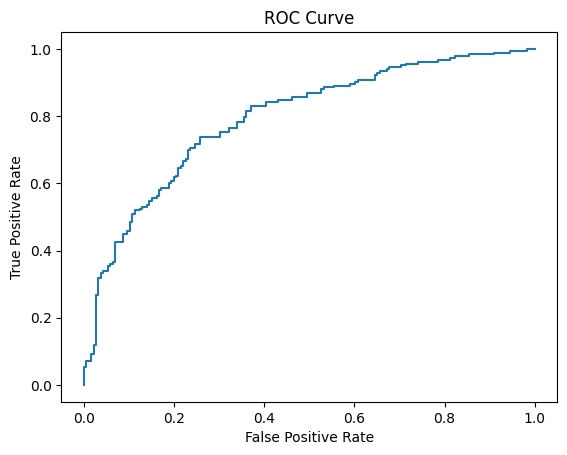

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_spectrogram, test_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

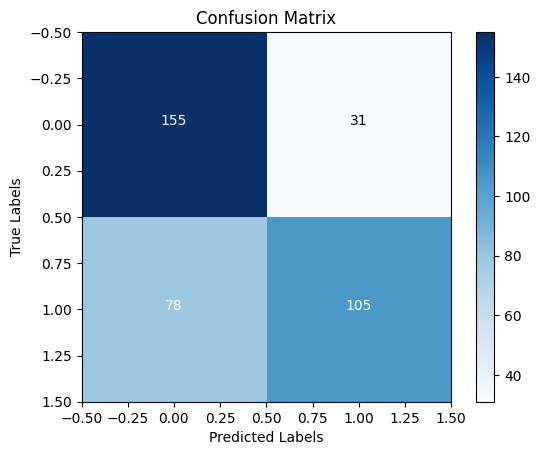

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred_binary = np.round(test_predictions).astype(int)

cm = confusion_matrix(y_test_spectrogram, y_pred_binary)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

12/12 [==============================] - 6s 464ms/step
Testing Accuracy: 0.7342465753424657
Testing F1 Score: 0.5907172995780591
Testing AUC: 0.8069562016930438


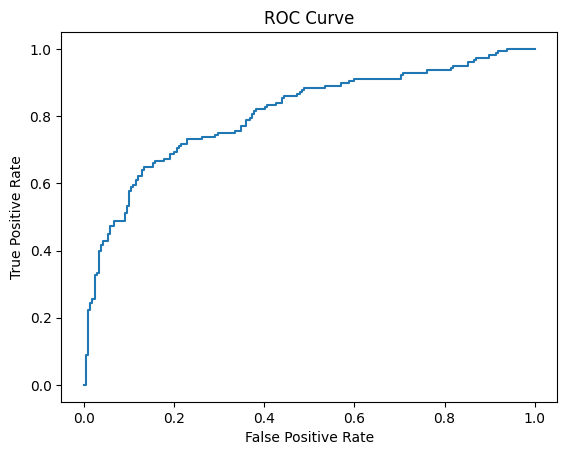

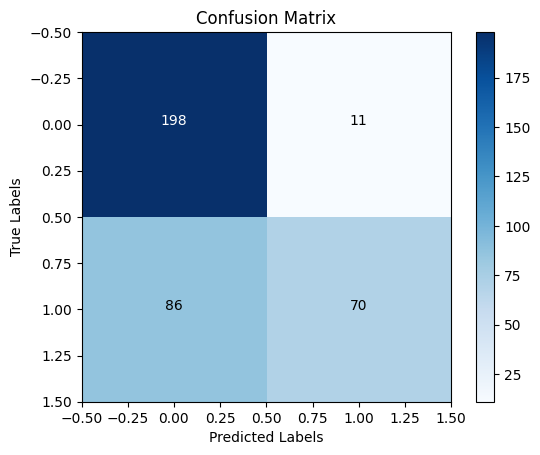

In [ ]:
## ODIA
test_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Odia_test.csv'
spectrogram_test_path = '/content/drive/MyDrive/adima/Spectrogram/Odia/test'

test_annotations = pd.read_csv(test_annotations_path)

X_test_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
y_test_spectrogram = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

test_predictions = cnn_model.predict(X_test_spectrogram)
test_accuracy = accuracy_score(y_test_spectrogram, np.round(test_predictions))
test_f1_score = f1_score(y_test_spectrogram, np.round(test_predictions))
test_auc = roc_auc_score(y_test_spectrogram, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)
print("Testing AUC:", test_auc)

fpr, tpr, thresholds = roc_curve(y_test_spectrogram, test_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_pred_binary = np.round(test_predictions).astype(int)
cm = confusion_matrix(y_test_spectrogram, y_pred_binary)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

12/12 [==============================] - 7s 558ms/step
Testing Accuracy: 0.7076502732240437
Testing F1 Score: 0.6192170818505338
Testing AUC: 0.8102668543532301


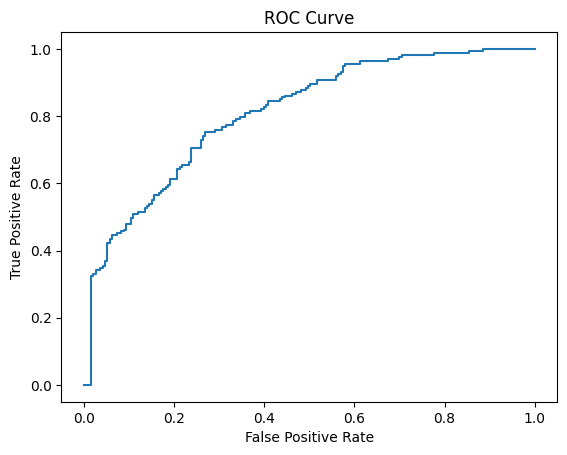

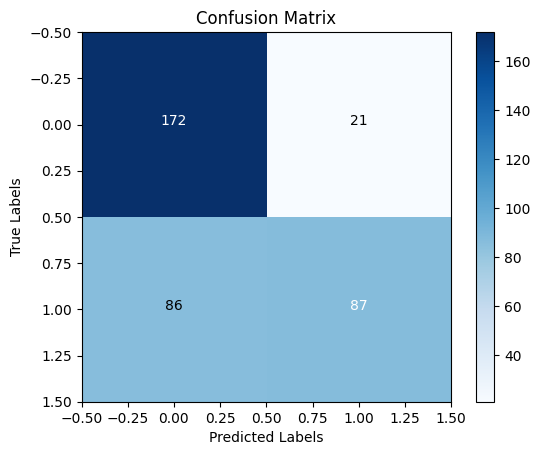

In [ ]:
## HARYANVI
test_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Haryanvi_test.csv'
spectrogram_test_path = '/content/drive/MyDrive/adima/Spectrogram/Haryanvi/test'

test_annotations = pd.read_csv(test_annotations_path)

X_test_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
y_test_spectrogram = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

test_predictions = cnn_model.predict(X_test_spectrogram)
test_accuracy = accuracy_score(y_test_spectrogram, np.round(test_predictions))
test_f1_score = f1_score(y_test_spectrogram, np.round(test_predictions))
test_auc = roc_auc_score(y_test_spectrogram, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)
print("Testing AUC:", test_auc)

fpr, tpr, thresholds = roc_curve(y_test_spectrogram, test_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_pred_binary = np.round(test_predictions).astype(int)
cm = confusion_matrix(y_test_spectrogram, y_pred_binary)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

11/11 [==============================] - 4s 402ms/step
Testing Accuracy: 0.6309523809523809
Testing F1 Score: 0.6436781609195402
Testing AUC: 0.756779531178183


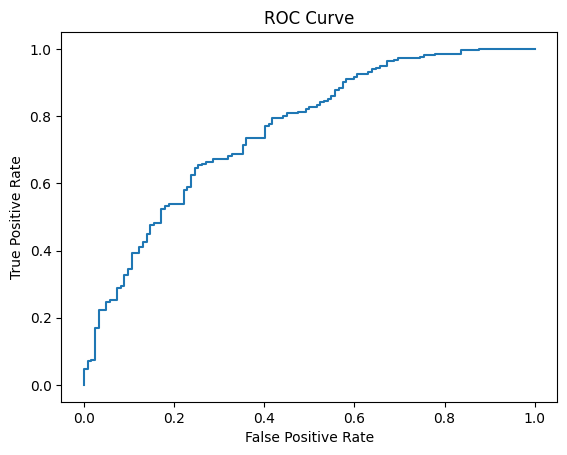

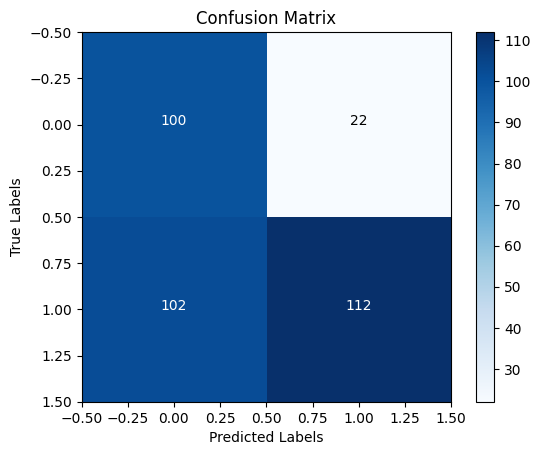

In [ ]:
## BHOJPURI
test_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Bhojpuri_test.csv'
spectrogram_test_path = '/content/drive/MyDrive/adima/Spectrogram/Bhojpuri/test'

test_annotations = pd.read_csv(test_annotations_path)

X_test_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
y_test_spectrogram = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

test_predictions = cnn_model.predict(X_test_spectrogram)
test_accuracy = accuracy_score(y_test_spectrogram, np.round(test_predictions))
test_f1_score = f1_score(y_test_spectrogram, np.round(test_predictions))
test_auc = roc_auc_score(y_test_spectrogram, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)
print("Testing AUC:", test_auc)

fpr, tpr, thresholds = roc_curve(y_test_spectrogram, test_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_pred_binary = np.round(test_predictions).astype(int)
cm = confusion_matrix(y_test_spectrogram, y_pred_binary)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

12/12 [==============================] - 6s 480ms/step
Testing Accuracy: 0.6594594594594595
Testing F1 Score: 0.6399999999999999
Testing AUC: 0.8004930606281959


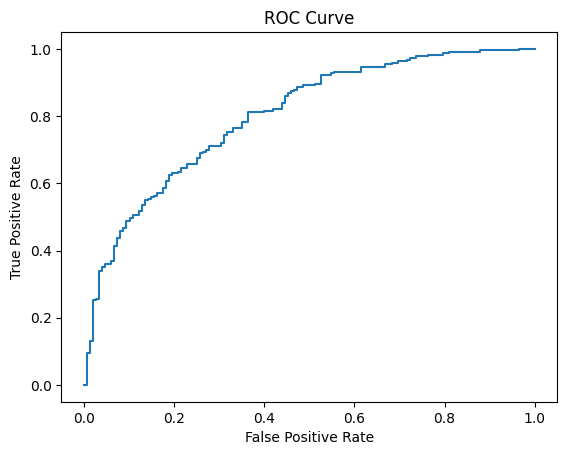

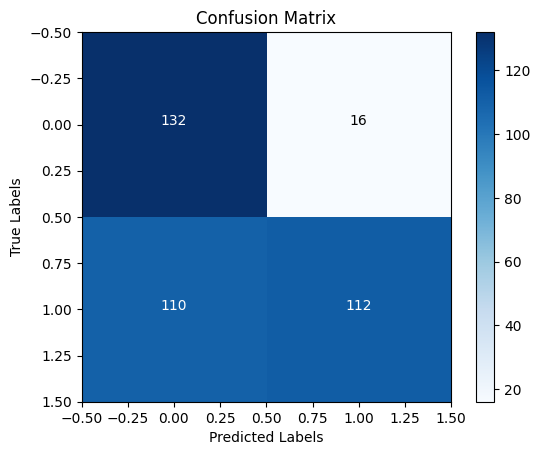

In [ ]:
## BENGALI
test_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Bengali_test.csv'
spectrogram_test_path = '/content/drive/MyDrive/adima/Spectrogram/Bengali/test'

test_annotations = pd.read_csv(test_annotations_path)

X_test_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
y_test_spectrogram = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

test_predictions = cnn_model.predict(X_test_spectrogram)
test_accuracy = accuracy_score(y_test_spectrogram, np.round(test_predictions))
test_f1_score = f1_score(y_test_spectrogram, np.round(test_predictions))
test_auc = roc_auc_score(y_test_spectrogram, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)
print("Testing AUC:", test_auc)

fpr, tpr, thresholds = roc_curve(y_test_spectrogram, test_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_pred_binary = np.round(test_predictions).astype(int)
cm = confusion_matrix(y_test_spectrogram, y_pred_binary)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

12/12 [==============================] - 8s 627ms/step
Testing Accuracy: 0.7493261455525606
Testing F1 Score: 0.4918032786885245
Testing AUC: 0.7625324114088159


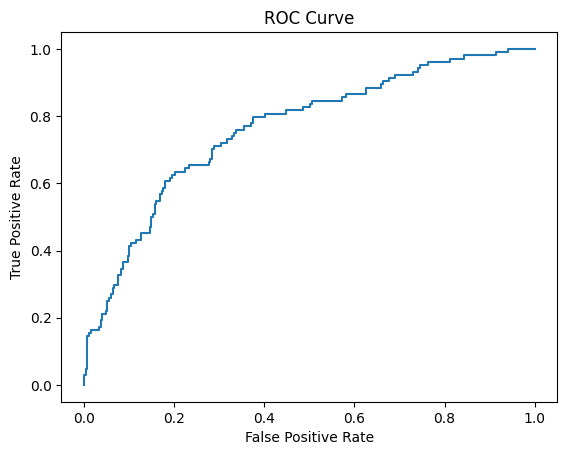

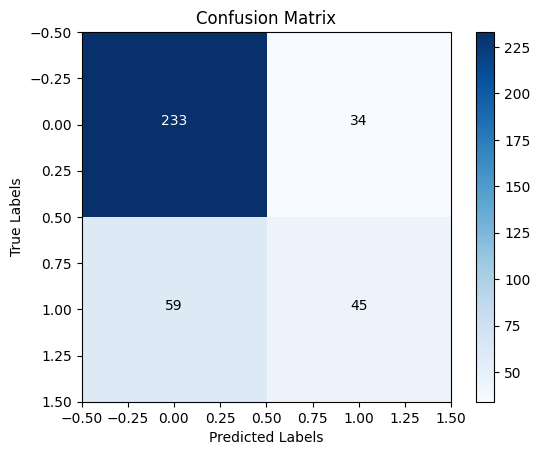

In [ ]:
## TAMIL
test_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Tamil_test.csv'
spectrogram_test_path = '/content/drive/MyDrive/adima/Spectrogram/Tamil/test'

test_annotations = pd.read_csv(test_annotations_path)

X_test_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
y_test_spectrogram = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

test_predictions = cnn_model.predict(X_test_spectrogram)
test_accuracy = accuracy_score(y_test_spectrogram, np.round(test_predictions))
test_f1_score = f1_score(y_test_spectrogram, np.round(test_predictions))
test_auc = roc_auc_score(y_test_spectrogram, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)
print("Testing AUC:", test_auc)

fpr, tpr, thresholds = roc_curve(y_test_spectrogram, test_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_pred_binary = np.round(test_predictions).astype(int)
cm = confusion_matrix(y_test_spectrogram, y_pred_binary)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

12/12 [==============================] - 14s 1s/step
Testing Accuracy: 0.7688172043010753
Testing F1 Score: 0.556701030927835
Testing AUC: 0.7968194890881408


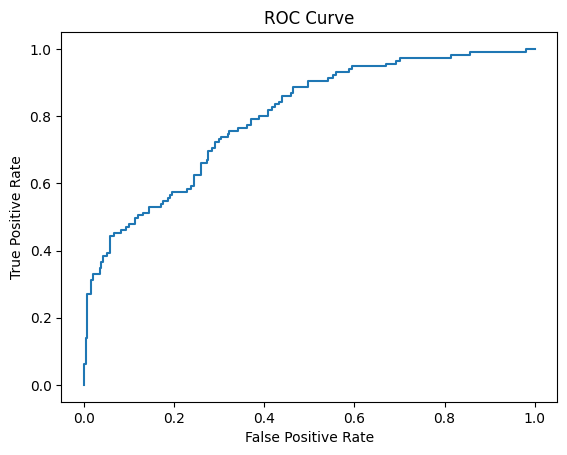

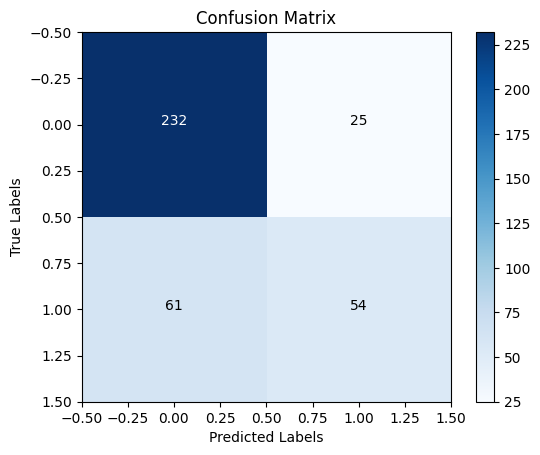

In [ ]:
## MALAYALAM
test_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Malayalam_test.csv'
spectrogram_test_path = '/content/drive/MyDrive/adima/Spectrogram/Malayalam/test'

test_annotations = pd.read_csv(test_annotations_path)

X_test_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
y_test_spectrogram = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

test_predictions = cnn_model.predict(X_test_spectrogram)
test_accuracy = accuracy_score(y_test_spectrogram, np.round(test_predictions))
test_f1_score = f1_score(y_test_spectrogram, np.round(test_predictions))
test_auc = roc_auc_score(y_test_spectrogram, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)
print("Testing AUC:", test_auc)

fpr, tpr, thresholds = roc_curve(y_test_spectrogram, test_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_pred_binary = np.round(test_predictions).astype(int)
cm = confusion_matrix(y_test_spectrogram, y_pred_binary)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

12/12 [==============================] - 5s 406ms/step
Testing Accuracy: 0.7384196185286104
Testing F1 Score: 0.7272727272727272
Testing AUC: 0.8253212755830557


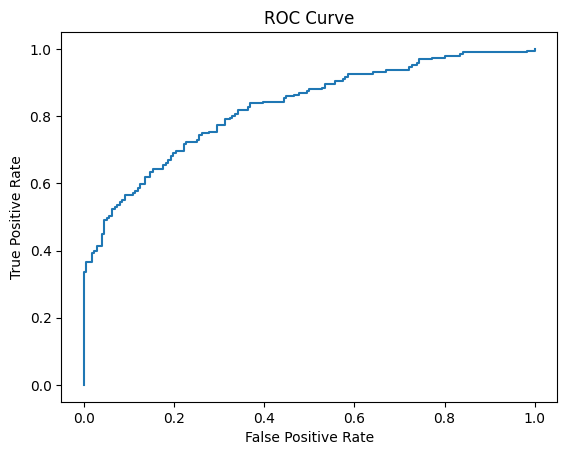

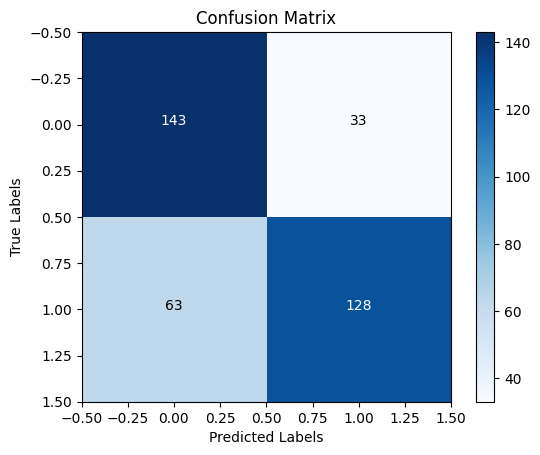

In [ ]:
## Punjabi
test_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Punjabi_test.csv'
spectrogram_test_path = '/content/drive/MyDrive/adima/Spectrogram/Punjabi/test'

test_annotations = pd.read_csv(test_annotations_path)

X_test_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
y_test_spectrogram = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

test_predictions = cnn_model.predict(X_test_spectrogram)
test_accuracy = accuracy_score(y_test_spectrogram, np.round(test_predictions))
test_f1_score = f1_score(y_test_spectrogram, np.round(test_predictions))
test_auc = roc_auc_score(y_test_spectrogram, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)
print("Testing AUC:", test_auc)

fpr, tpr, thresholds = roc_curve(y_test_spectrogram, test_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_pred_binary = np.round(test_predictions).astype(int)
cm = confusion_matrix(y_test_spectrogram, y_pred_binary)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

12/12 [==============================] - 10s 839ms/step
Testing Accuracy: 0.7398373983739838
Testing F1 Score: 0.5428571428571429
Testing AUC: 0.7924423541707492


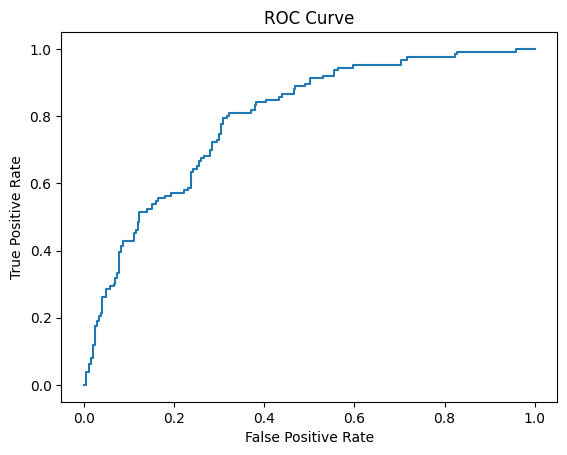

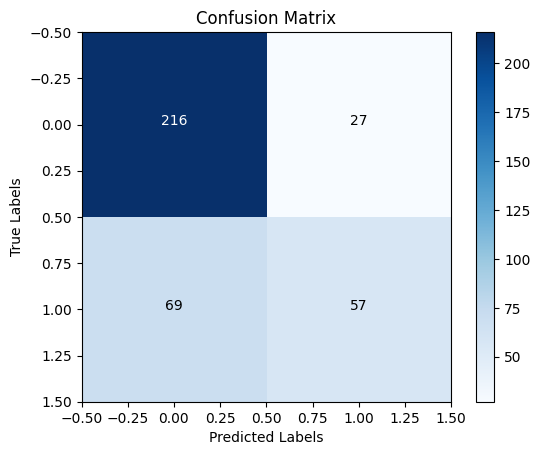

In [ ]:
## KANNADA
test_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Kannada_test.csv'
spectrogram_test_path = '/content/drive/MyDrive/adima/Spectrogram/Kannada/test'

test_annotations = pd.read_csv(test_annotations_path)

X_test_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
y_test_spectrogram = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

test_predictions = cnn_model.predict(X_test_spectrogram)
test_accuracy = accuracy_score(y_test_spectrogram, np.round(test_predictions))
test_f1_score = f1_score(y_test_spectrogram, np.round(test_predictions))
test_auc = roc_auc_score(y_test_spectrogram, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)
print("Testing AUC:", test_auc)

fpr, tpr, thresholds = roc_curve(y_test_spectrogram, test_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_pred_binary = np.round(test_predictions).astype(int)
cm = confusion_matrix(y_test_spectrogram, y_pred_binary)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

12/12 [==============================] - 5s 402ms/step
Testing Accuracy: 0.7596685082872928
Testing F1 Score: 0.5538461538461538
Testing AUC: 0.7616272677295216


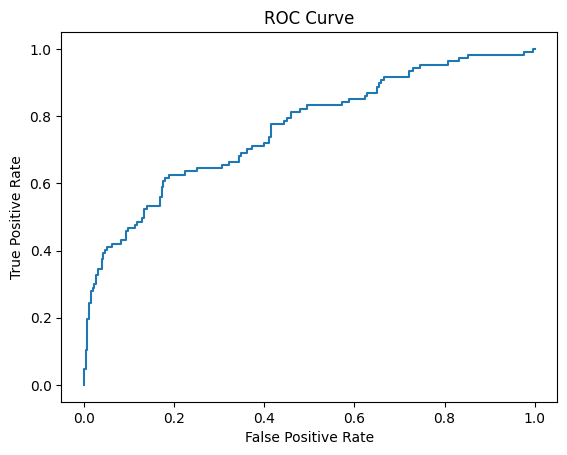

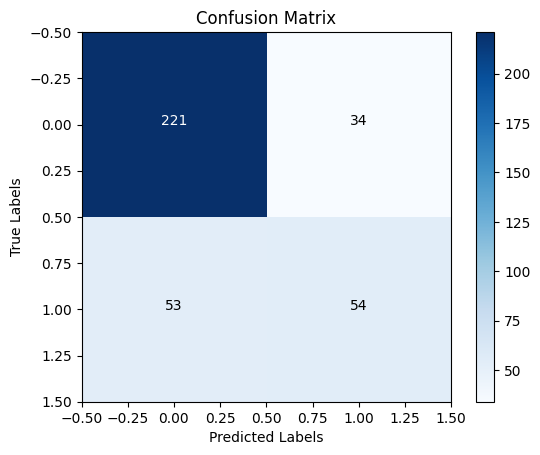

In [ ]:
## Gujarati
test_annotations_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Gujarati_test.csv'
spectrogram_test_path = '/content/drive/MyDrive/adima/Spectrogram/Gujarati/test'

test_annotations = pd.read_csv(test_annotations_path)

X_test_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
y_test_spectrogram = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

test_predictions = cnn_model.predict(X_test_spectrogram)
test_accuracy = accuracy_score(y_test_spectrogram, np.round(test_predictions))
test_f1_score = f1_score(y_test_spectrogram, np.round(test_predictions))
test_auc = roc_auc_score(y_test_spectrogram, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)
print("Testing AUC:", test_auc)

fpr, tpr, thresholds = roc_curve(y_test_spectrogram, test_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_pred_binary = np.round(test_predictions).astype(int)
cm = confusion_matrix(y_test_spectrogram, y_pred_binary)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

##LNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models, layers
from kerasncp.tf import LTCCell
from tensorflow.keras.layers import RNN
from tensorflow.keras import models, layers, preprocessing
from ncps.wirings import AutoNCP
from ncps.tf import LTC
import tensorflow as tf
from ncps import wirings
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint
import kerasncp as kncp
from kerasncp.tf import LTCCell
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [ ]:
# Load annotation data
annotation_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Bengali_train.csv'
annotation_data = pd.read_csv(annotation_path)

# Load text data
text_path = '/content/drive/MyDrive/adima/audios-001/Transcriptions/transcription_bengali.csv'
text_data = pd.read_csv(text_path)

# Merge annotation and text data
merged_data = pd.merge(annotation_data, text_data, left_on='filename', right_on='File Name', how='inner')

# Filter out unnecessary columns
merged_data = merged_data[['Transcription', 'label']]

# Prepare data for training
X_text = merged_data['Transcription'].values
y = merged_data['label'].values

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train and test sets
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# Tokenize text data
max_words = 10000  # Maximum number of words to tokenize
max_len = 100  # Maximum length of each sequence
tokenizer = preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_text)
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences to ensure uniform length
X_train_pad = preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
# Define the LTC cell
wiring = AutoNCP(100, 25)
rnn_cell = LTCCell(wiring)

# Define the model
model = models.Sequential([
    layers.Embedding(max_words, 32, input_length=max_len),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Reshape((1, -1)),  # Reshape for LSTM
    layers.RNN(rnn_cell, return_sequences=True),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Train the model
model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

In [ ]:
# Load testing annotation data
testing_annotation_path = '/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/Bengali_test.csv'
testing_annotation_data = pd.read_csv(testing_annotation_path)

# Load testing text data
testing_text_path = '/content/drive/MyDrive/adima/audios-001/Transcriptions/transcription_bengali.csv'
testing_text_data = pd.read_csv(testing_text_path)

# Merge testing annotation and text data
merged_testing_data = pd.merge(testing_annotation_data, testing_text_data, left_on='filename', right_on='File Name', how='inner')

# Filter out unnecessary columns
merged_testing_data = merged_testing_data[['Transcription', 'label']]

# Prepare data for testing
X_test_text = merged_testing_data['Transcription'].values
y_test = merged_testing_data['label'].values

# Encode labels
y_test_encoded = label_encoder.transform(y_test)

# Tokenize and pad sequences for testing data
X_test_seq = tokenizer.texts_to_sequences(X_test_text)
X_test_pad = preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype(int)

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
f1 = f1_score(y_test_encoded, y_pred)
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix as heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## FUSION

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Load predictions from CNN model
cnn_train_predictions = cnn_model.predict(X_train_spectrogram)
cnn_test_predictions = cnn_model.predict(X_test_spectrogram)

In [ ]:
# Load predictions from LSTM model
lnn_train_predictions = model.predict(X_train_pad)
lnn_test_predictions = model.predict(X_test_pad)

In [ ]:
# Calculate accuracies
cnn_accuracy = accuracy_score(y_test_spectrogram, np.round(cnn_test_predictions))
lnn_accuracy = accuracy_score(y_test_encoded, np.round(lnn_test_predictions))

# Assign weights based on accuracies
total_accuracy = cnn_accuracy + lnn_accuracy
cnn_weight = cnn_accuracy / total_accuracy
lnn_weight = lnn_accuracy / total_accuracy

print("CNN Accuracy:", cnn_accuracy)
print("LNN Accuracy:", lnn_accuracy)
print("Assigned weights - CNN:", cnn_weight, "LNN:", lnn_weight)

In [ ]:
# Combine predictions selectively where both models have predictions
train_combined_predictions = []
for i in range(len(y_train)):
    if i < len(cnn_train_predictions) and i < len(lstm_train_predictions):
        combined_pred = np.round((cnn_weight * cnn_train_predictions[i]) + (lstm_weight * lstm_train_predictions[i]))
    elif i < len(cnn_train_predictions):
        combined_pred = np.round(cnn_weight * cnn_train_predictions[i])
    else:
        combined_pred = np.round(lstm_weight * lstm_train_predictions[i])
    train_combined_predictions.append(combined_pred)

# Combine predictions for test data similarly
test_combined_predictions = []
for i in range(len(y_test)):
    if i < len(cnn_test_predictions) and i < len(lstm_test_predictions):
        combined_pred = np.round((cnn_weight * cnn_test_predictions[i]) + (lstm_weight * lstm_test_predictions[i]))
    elif i < len(cnn_test_predictions):
        combined_pred = np.round(cnn_weight * cnn_test_predictions[i])
    else:
        combined_pred = np.round(lstm_weight * lstm_test_predictions[i])
    test_combined_predictions.append(combined_pred)

In [ ]:
print(train_combined_predictions)
print(test_combined_predictions)

In [ ]:
# Convert true labels to match the format of predicted labels
y_test = np.array([1 if label == 'Yes' else 0 for label in y_test])
print("Unique values in y_train_pred_format:", np.unique(y_test))

In [ ]:
# Calculate accuracy and other metrics
test_accuracy = accuracy_score(y_test, test_combined_predictions)
test_f1_score = f1_score(y_test, test_combined_predictions)
test_auc = roc_auc_score(y_test, test_combined_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)
print("Testing AUC:", test_auc)

In [ ]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_combined_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, test_combined_predictions)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()


#CROSS

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models, layers
from kerasncp.tf import LTCCell
from tensorflow.keras.layers import RNN
from tensorflow.keras import models, layers, preprocessing
from ncps.wirings import AutoNCP
from ncps.tf import LTC
import tensorflow as tf
from ncps import wirings
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint
import kerasncp as kncp
from kerasncp.tf import LTCCell
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

def load_spectrogram_image(filename, spectrogram_path):
    img_path = os.path.join(spectrogram_path, filename.replace('.wav', '_spectrogram.png'))
    img = load_img(img_path, color_mode="grayscale", target_size=(100, 100))
    img_array = img_to_array(img)
    return img_array / 255.0

def train_cnn_model(language):
    train_annotations_path = f'/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_train.csv'
    test_annotations_path = f'/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_test.csv'
    spectrogram_train_path = f'/content/drive/MyDrive/adima/Spectrogram/{language}/train'
    spectrogram_test_path = f'/content/drive/MyDrive/adima/Spectrogram/{language}/test'

    train_annotations = pd.read_csv(train_annotations_path)
    test_annotations = pd.read_csv(test_annotations_path)

    X_train_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_train_path) for filename in train_annotations['filename']])
    y_train_spectrogram = np.array(train_annotations['label'].map({'Yes': 1, 'No': 0}))
    X_test_spectrogram = np.array([load_spectrogram_image(filename, spectrogram_test_path) for filename in test_annotations['filename']])
    y_test_spectrogram = np.array(test_annotations['label'].map({'Yes': 1, 'No': 0}))

    cnn_model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with early stopping
    history = cnn_model.fit(X_train_spectrogram, y_train_spectrogram, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    return cnn_model, X_test_spectrogram, y_test_spectrogram, y_train_spectrogram


def test_cnn_model(model, X_test_spectrogram, y_test_spectrogram):
    # Testing code for CNN model
    test_predictions = model.predict(X_test_spectrogram)
    test_accuracy = accuracy_score(y_test_spectrogram, np.round(test_predictions))
    return test_accuracy

def train_lnn_model(language):
    # Training code for LNN model
    annotation_path = f'/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_train.csv'
    text_path = f'/content/drive/MyDrive/adima/audios-001/Transcriptions/transcription_{language}.csv'

    annotation_data = pd.read_csv(annotation_path)
    text_data = pd.read_csv(text_path)

    merged_data = pd.merge(annotation_data, text_data, left_on='filename', right_on='File Name', how='inner')
    merged_data = merged_data[['Transcription', 'label']]

    X_text = merged_data['Transcription'].values
    y = merged_data['label'].values

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

    max_words = 10000
    max_len = 100
    tokenizer = preprocessing.text.Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train_text)
    X_train_seq = tokenizer.texts_to_sequences(X_train_text)
    X_test_seq = tokenizer.texts_to_sequences(X_test_text)

    X_train_pad = preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_len)
    X_test_pad = preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len)

    wiring = AutoNCP(100, 25)
    rnn_cell = LTCCell(wiring)

    model = models.Sequential([
        layers.Embedding(max_words, 32, input_length=max_len),
        layers.Conv1D(32, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),
        layers.Flatten(),
        layers.Reshape((1, -1)),
        layers.RNN(rnn_cell, return_sequences=True),
        layers.GlobalAveragePooling1D(),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

    # Load testing annotation data
    testing_annotation_path =f'/content/drive/MyDrive/adima/PRIMA-20240228T071801Z-002/PRIMA/annotations/{language}_test.csv'
    testing_annotation_data = pd.read_csv(testing_annotation_path)

    # Load testing text data
    testing_text_path =f'/content/drive/MyDrive/adima/audios-001/Transcriptions/transcription_{language}.csv'
    testing_text_data = pd.read_csv(testing_text_path)

    # Merge testing annotation and text data
    merged_testing_data = pd.merge(testing_annotation_data, testing_text_data, left_on='filename', right_on='File Name', how='inner')

    # Filter out unnecessary columns
    merged_testing_data = merged_testing_data[['Transcription', 'label']]

    # Prepare data for testing
    X_test_text = merged_testing_data['Transcription'].values
    y_test = merged_testing_data['label'].values

    # Encode labels
    y_test_encoded = label_encoder.transform(y_test)

    # Tokenize and pad sequences for testing data
    X_test_seq = tokenizer.texts_to_sequences(X_test_text)
    X_test_pad = preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len)

    return model, X_test_pad, y_test_encoded

def test_lnn_model(model, X_test_pad, y_test_encoded):
    # Testing code for LNN model
    y_pred = model.predict(X_test_pad)
    y_pred = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_test_encoded, y_pred)
    return accuracy

import numpy as np
from skimage.transform import resize

import numpy as np
from skimage.transform import resize

def main():
    languages = ["Bhojpuri", "Gujarati", "Haryanvi", "Hindi", "Kannada", "Malayalam", "Odia", "Punjabi", "Tamil", "Bengali"]

    cnn_results = np.zeros((10, 10))  # Initialize CNN results table
    lnn_results = np.zeros((10, 10))  # Initialize LNN results table
    weighted_avg_results = np.zeros((10, 10))  # Initialize weighted average results table

    for i, src_language in enumerate(languages):
        # Train CNN model
        cnn_model, X_test_spectrogram, y_test_spectrogram, _ = train_cnn_model(src_language)

        # Train LNN model
        lnn_model, X_test_pad, y_test_encoded = train_lnn_model(src_language)

        for j, tgt_language in enumerate(languages):
            # Test CNN model on target language
            cnn_accuracy = test_cnn_model(cnn_model, X_test_spectrogram, y_test_spectrogram)
            cnn_results[i, j] = cnn_accuracy

            # Test LNN model on target language
            lnn_accuracy = test_lnn_model(lnn_model, X_test_pad, y_test_encoded)
            lnn_results[i, j] = lnn_accuracy

            # Combine results using weighted average
            total_accuracy = cnn_accuracy + lnn_accuracy
            cnn_weight = cnn_accuracy / total_accuracy
            lnn_weight = lnn_accuracy / total_accuracy

            # Calculate weighted average of predictions
            cnn_predictions = cnn_model.predict(X_test_spectrogram)
            lnn_predictions = lnn_model.predict(X_test_pad)

            # Resize lnn_predictions to match the shape of cnn_predictions
            lnn_predictions_resized = resize(lnn_predictions, cnn_predictions.shape)

            # Perform weighted average
            combined_predictions = []
            for idx in range(len(y_test_spectrogram)):
                if idx < len(cnn_predictions) and idx < len(lnn_predictions_resized):
                    combined_pred = np.round((cnn_weight * cnn_predictions[idx]) + (lnn_weight * lnn_predictions_resized[idx]))
                elif idx < len(cnn_predictions):
                    combined_pred = np.round(cnn_weight * cnn_predictions[idx])
                else:
                    combined_pred = np.round(lnn_weight * lnn_predictions_resized[idx])
                combined_predictions.append(combined_pred)

            # Calculate accuracy for the weighted average
            weighted_avg_accuracy = accuracy_score(y_test_spectrogram, combined_predictions)
            weighted_avg_results[i, j] = weighted_avg_accuracy

    # Print CNN results table
    print("CNN Results Table:")
    for i, src_language in enumerate(languages):
        print(f"{src_language}: ", end="")
        for j, tgt_language in enumerate(languages):
            print(f"{cnn_results[i, j]:.4f}  ", end="")
        print()

    # Print LNN results table
    print("\nLNN Results Table:")
    for i, src_language in enumerate(languages):
        print(f"{src_language}: ", end="")
        for j, tgt_language in enumerate(languages):
            print(f"{lnn_results[i, j]:.4f}  ", end="")
        print()

    # Print weighted average results table
    print("\nWeighted Average Results Table:")
    for i, src_language in enumerate(languages):
        print(f"{src_language}: ", end="")
        for j, tgt_language in enumerate(languages):
            print(f"{weighted_avg_results[i, j]:.4f}  ", end="")
        print()

if __name__ == "__main__":
    main()

Epoch 1/50
19/19 [==============================] - 45s 2s/step - loss: 0.6897 - accuracy: 0.6079 - val_loss: 0.6047 - val_accuracy: 0.7303
Epoch 2/50
19/19 [==============================] - 35s 2s/step - loss: 0.6443 - accuracy: 0.6507 - val_loss: 0.5845 - val_accuracy: 0.7303
Epoch 3/50
19/19 [==============================] - 35s 2s/step - loss: 0.6372 - accuracy: 0.6507 - val_loss: 0.5713 - val_accuracy: 0.7303
Epoch 4/50
19/19 [==============================] - 40s 2s/step - loss: 0.6564 - accuracy: 0.6590 - val_loss: 0.5826 - val_accuracy: 0.7303
Epoch 5/50
19/19 [==============================] - 35s 2s/step - loss: 0.6355 - accuracy: 0.6507 - val_loss: 0.5612 - val_accuracy: 0.7303
Epoch 6/50
19/19 [==============================] - 35s 2s/step - loss: 0.6219 - accuracy: 0.6689 - val_loss: 0.6226 - val_accuracy: 0.8026
Epoch 7/50
19/19 [==============================] - 35s 2s/step - loss: 0.6047 - accuracy: 0.6903 - val_loss: 0.5222 - val_accuracy: 0.7697
Epoch 8/50
19/19 [==

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Initialize the arrays for the corrected accuracy table
corrected_weighted_avg_results = np.zeros((10, 10))

for i, src_language in enumerate(languages):
    for j, tgt_language in enumerate(languages):
        # Retrieve the weighted average accuracy from the original table
        weighted_avg_accuracy = weighted_avg_results[i, j]

        # Calculate CNN accuracy for the corresponding source language
        cnn_accuracy = cnn_results[i, j]

        # Calculate LNN accuracy for the corresponding source language
        lnn_accuracy = lnn_results[i, j]

        # Calculate the corrected weighted average accuracy
        total_accuracy = cnn_accuracy + lnn_accuracy
        cnn_weight = cnn_accuracy / total_accuracy
        lnn_weight = lnn_accuracy / total_accuracy
        corrected_weighted_avg_accuracy = cnn_weight * cnn_accuracy + lnn_weight * lnn_accuracy

        # Assign the corrected weighted average accuracy to the table
        corrected_weighted_avg_results[i, j] = corrected_weighted_avg_accuracy

# Print the corrected weighted average results table
print("\nCorrected Weighted Average Results Table:")
for i, src_language in enumerate(languages):
    print(f"{src_language}: ", end="")
    for j, tgt_language in enumerate(languages):
        print(f"{corrected_weighted_avg_results[i, j]:.4f}  ", end="")
    print()

NameError: name 'weighted_avg_results' is not defined